# Libraries

In [2]:
#install.packages("gbm")
#install.packages("xgboost")

In [1]:
library(tidyverse)

# Modeling packages
library(caret)
library(gbm)      # Implementacion de al forma clasica de gradient boosting en R
library(xgboost)  # General implementacion para extreme gradient boosting
library(gridExtra)
library(recipes)
library(pdp)
library(vip)



── Attaching packages ─────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loaded gbm 2.1.8


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘recipes’


The following object is masked from ‘package:stringr’:

    fixed


The following object is masked 

# Load data

In [4]:
path_data = '/home/creyesp/Projects/repos/r-course/data/online_shoppers_intention.csv'

column_parser <- cols(
    Administrative = col_character(),
    Administrative_Duration = col_double(),
    Informational = col_character(),
    Informational_Duration = col_double(),
    ProductRelated = col_character(),
    ProductRelated_Duration = col_double(),
    BounceRates = col_double(),
    ExitRates = col_double(),
    PageValues = col_double(),
    SpecialDay = col_double(),
    Month = col_character(),
    OperatingSystems = col_character(),
    Browser = col_character(),
    Region = col_character(),
    TrafficType = col_character(),
    VisitorType = col_character(),
    Weekend = col_character(),
    Revenue = col_logical()
)

data = readr::read_delim(path_data, delim=',', col_types = column_parser)

In [5]:
categorical = c(
    'Month',
    'VisitorType',
    'OperatingSystems',
    'Browser',
    'Region',
    'TrafficType',
    'Administrative',
    'Informational',
    'ProductRelated',
    'Weekend'
)
numerical = c(
    'Administrative_Duration',
    'Informational_Duration',
    'ProductRelated_Duration',
    'BounceRates',
    'ExitRates',
    'PageValues',
    'SpecialDay'
)
outcome = 'Revenue'

# Split Dataset

In [6]:
set.seed(42)

index_train <- createDataPartition(data$Revenue, p = 0.8, list = FALSE)
retention_train <- data[index_train, ]
retention_test  <- data[-index_train, ]

head(retention_train)

Warning message:
“The `i` argument of ``[`()` can't be a matrix as of tibble 3.0.0.
Convert to a vector.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
0,0,0,0,1,0.000000,0.20,0.20,0,0.0,Feb,1,1,1,1,Returning_Visitor,FALSE,FALSE
0,0,0,0,2,64.000000,0.00,0.10,0,0.0,Feb,2,2,1,2,Returning_Visitor,FALSE,FALSE
0,-1,0,-1,1,-1.000000,0.20,0.20,0,0.0,Feb,4,1,9,3,Returning_Visitor,FALSE,FALSE
0,0,0,0,2,2.666667,0.05,0.14,0,0.0,Feb,3,2,2,4,Returning_Visitor,FALSE,FALSE
0,0,0,0,10,627.500000,0.02,0.05,0,0.0,Feb,3,3,1,4,Returning_Visitor,TRUE,FALSE
0,-1,0,-1,1,-1.000000,0.20,0.20,0,0.4,Feb,2,4,3,3,Returning_Visitor,FALSE,FALSE


# Overview

In [7]:
head(retention_train[categorical])

Month,VisitorType,OperatingSystems,Browser,Region,TrafficType,Administrative,Informational,ProductRelated,Weekend
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Feb,Returning_Visitor,1,1,1,1,0,0,1,FALSE
Feb,Returning_Visitor,2,2,1,2,0,0,2,FALSE
Feb,Returning_Visitor,4,1,9,3,0,0,1,FALSE
Feb,Returning_Visitor,3,2,2,4,0,0,2,FALSE
Feb,Returning_Visitor,3,3,1,4,0,0,10,TRUE
Feb,Returning_Visitor,2,4,3,3,0,0,1,FALSE


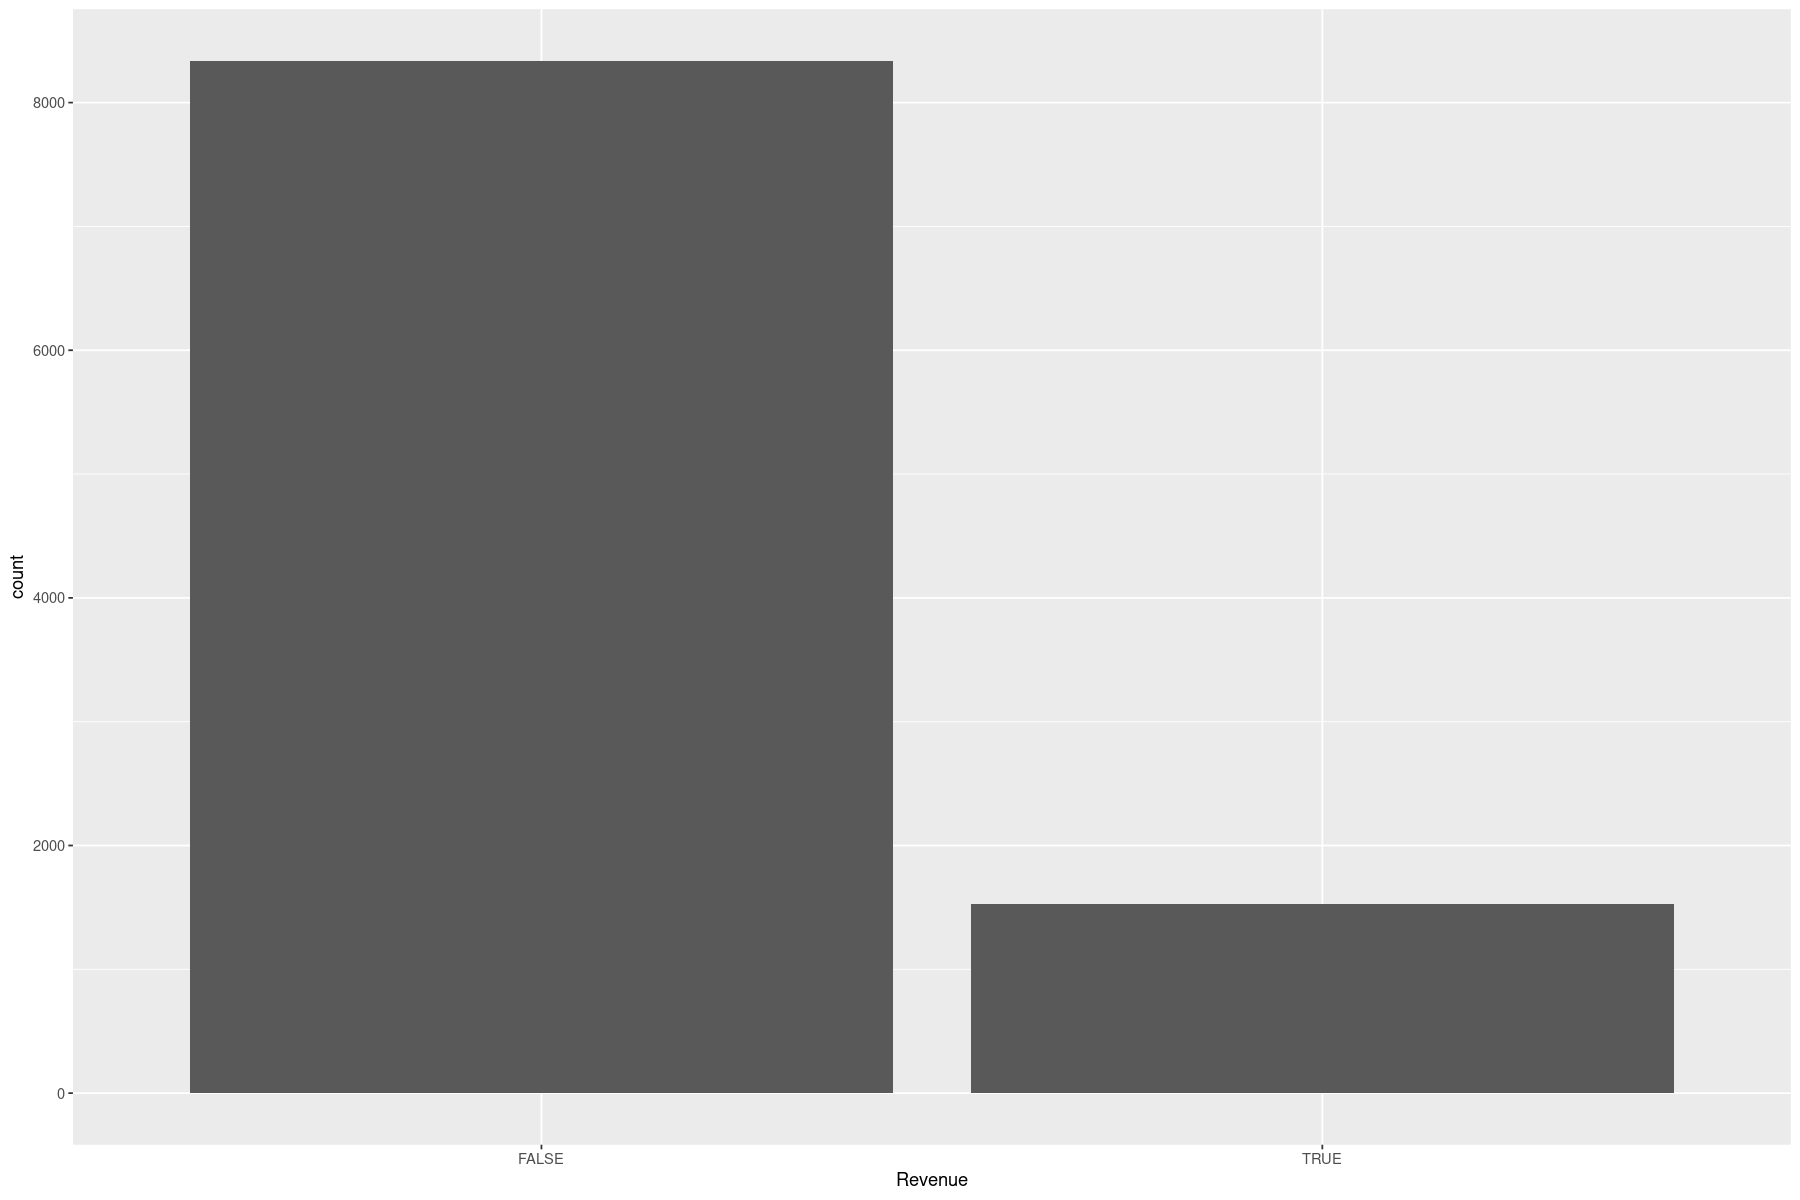

In [8]:
retention_train %>% 
    ggplot(aes(Revenue)) + 
        geom_bar()

In [9]:
as.integer(retention_train$Revenue)

[1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [38] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  [75] 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [112] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [149] 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 [186] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 [223] 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 [260] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 [297] 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 [334] 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [371] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 [408] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [445] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 [482] 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 [519] 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 [556] 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [593] 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 [630] 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 [667] 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 [704] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [741] 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [778] 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [815] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 [852] 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [889] 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [926] 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0
 [963] 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0
[1000] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1037] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1
[1074] 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
[1111] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1148] 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1185] 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
[1222] 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
[1259] 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0
[1296] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0
[1333] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[1370] 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0
[1407] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0
[1444] 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
[1481] 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
[1518] 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
[1555] 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
[1592] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1
[1629] 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
[1666] 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1
[1703] 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
[1740] 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1
[1777] 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0
[1814] 0 0 0 0 0 0 1 1 0 0 0 0 0 0

# Loss function
La *loss function* es una medida que indica que tan bien los parámetros del modelo ajustan a los datos de entrenamiento y en general minimizan el error. Para los problemas de clasificación se suele usar la **Binary Cross entropy / Log Loss** dado que es diferenciable y eso facilita el proceso de optimización de los algoritmos.  
Como vimos en la clase de árboles se suele usar la entropía o el índice de gini como criterio para hacer la buscar del mejor split en un nodo (feature, threshold). Adicionalmente en el caso de las técnicas de boosting se usa la misma función para buscar en cada iteración el mejor árbol para reducir el error.

<img src="https://miro.medium.com/max/548/1*rdBw0E-My8Gu3f_BOB6GMA.png">


In [10]:
cost_func <- function(obs, pred){
    -(obs*log(pred, base = 2) + (1 - obs)*log(1 - pred, base = 2))
}
cost_func(1, 0.5)
cost_func(1, 0.2)
cost_func(1, 0.8)
cost_func(0, 0.5)
cost_func(0, 0.2)
cost_func(0, 0.8)

[1] 1

[1] 2.321928

[1] 0.3219281

[1] 1

[1] 0.3219281

[1] 2.321928

# GBM

**Hyperparameters**
La versión clásica de GBM tiene 2 tipos de hiper-parámetros:
   * boosting
   * específicos de los árboles

**Hiper-parámetros de Boosting**
* **Numero de arboles**: el número total de árboles en la secuencia. A diferencia de Bagging y RF donde el número de árboles raramente puede generar overfitting, en boosting el hecho de la dependencia con el error del árbol anterior lo hace propenso a hacer overfitting, en general este número puede variar en dependencia de los otros hiper-parámetros.
* **Learning rate (shrinkage)**: determina la contribución de cada árbol en el resultado final  y controla la velocidad con la que el algoritmo desciende. Este valor va entre $[0, 1]$ y valores típicos van entre $0.001$ - $0.3$. Valores más pequeños hacen más robusto a características específicas de cada árbol, permitiendo generalizar bien. Sin embargo, los valores pequeños pueden llevar a no encontrar el punto óptimo y quedar en un mínimo local. Generalmente valores más pequeños logran una mejor performance pero requiere de un número mayor de árboles en la secuencia.

**Hiper-parámetros propios de cada árbol**

* **Profundidad del árbol**: Controla la profundidad máxima de cada árbol. Los valores típicos van entre 3-8 pero no es raro ver árboles con profundidad 1. Valores bajos son computacionalmente eficiente pero requiere de más árboles en total. Sin embargo, los valores más grandes permiten capturar interacciones entre las features pero lo hace propenso a hacer overfitting.
* **Número mínimo de observaciones en un nodo**: controla la complejidad del árbol. Dado que los árboles tienden a ser poco profundos tiende a tener poco efecto. Valores típicos van entre 5-15. Valores grandes pueden ayudar a prevenir relaciones muy específicas entre variables (overfitting) pero para los casos de datasets desbalanceados, los valores pequeños pueden ayudar a detectar los casos de la clase minoritaria.


## Feature engineering

In [11]:
prep_retention <- recipe(Revenue ~ ., data = retention_train) %>%
    step_medianimpute(all_of(numerical)) %>% 
    step_string2factor(all_of(categorical)) %>% 
    step_knnimpute(all_of(categorical)) %>% 
    step_mutate(Revenue = as.integer(Revenue)) %>% 
    prep()
    
retention_train_clean  <-  bake(prep_retention, retention_train)
retention_test_clean  <-  bake(prep_retention, retention_test)

In [12]:
head(retention_train_clean)

Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>
0,0,0,0,1,0.000000,0.20,0.20,0,0.0,Feb,1,1,1,1,Returning_Visitor,FALSE,0
0,0,0,0,2,64.000000,0.00,0.10,0,0.0,Feb,2,2,1,2,Returning_Visitor,FALSE,0
0,-1,0,-1,1,-1.000000,0.20,0.20,0,0.0,Feb,4,1,9,3,Returning_Visitor,FALSE,0
0,0,0,0,2,2.666667,0.05,0.14,0,0.0,Feb,3,2,2,4,Returning_Visitor,FALSE,0
0,0,0,0,10,627.500000,0.02,0.05,0,0.0,Feb,3,3,1,4,Returning_Visitor,TRUE,0
0,-1,0,-1,1,-1.000000,0.20,0.20,0,0.4,Feb,2,4,3,3,Returning_Visitor,FALSE,0


## Modeling
En R hay un paquete llamada GBM que implementa *Gradient Boosting Machine* y tiene alguno de los siguientes hiperparametros
* **distribution** = nombre de la loss function. Para clasificación binaria "Logistic loss"/"Bernoulli loss"
* **n.trees** = número de iteraciones/árboles para entrenar (default=100)
* **shrinkage** = learning rate (default=0.1)
* **interaction.depth** = máxima profundidad del árbol (default=1)
* **n.minobsinnode** = mínimo de observaciones en un árbol (default=10)
* **bag.fraction** = fracción del total de observaciones que se usan para entrenar un nuevo árbol en cada iteración (default=0.5)
* **train.fraction** = fracción del total de observaciones que se usa para entrenar el modelo en cada iteración, el resto se usar para evaluar con un conjunto no visto en entrenamiento (default=1)
* **class.stratify.cv** = Si el problema es de clasificación de hace un sample estratificado para mantener la proporción del target (default=NULL)
* **cv.folds** = número de CV que se realizan (default=0)

### GBM model 1

In [13]:
set.seed(42)

retention_gbm1 <- gbm(
  formula = Revenue ~ .,
  data = retention_train_clean,
  distribution = "bernoulli",
  n.trees = 100,
  shrinkage = 0.1,
  interaction.depth = 1,
  n.minobsinnode = 10,
  bag.fraction = 0.5,
  class.stratify.cv = TRUE,
  cv.folds = 5
)

# Encuentra el numero de arboles que genera el menor error
best <- which.min(retention_gbm1$cv.error)

retention_gbm1$cv.error[best]

[1] 0.5577608

### Optimum iteration
GBM implementa una función para encontrar el valor óptimo de iteraciones donde se minimiza el error `gbm.perf`, adicionalmente te genera una gráfica del error en cada iteración

[1] 28

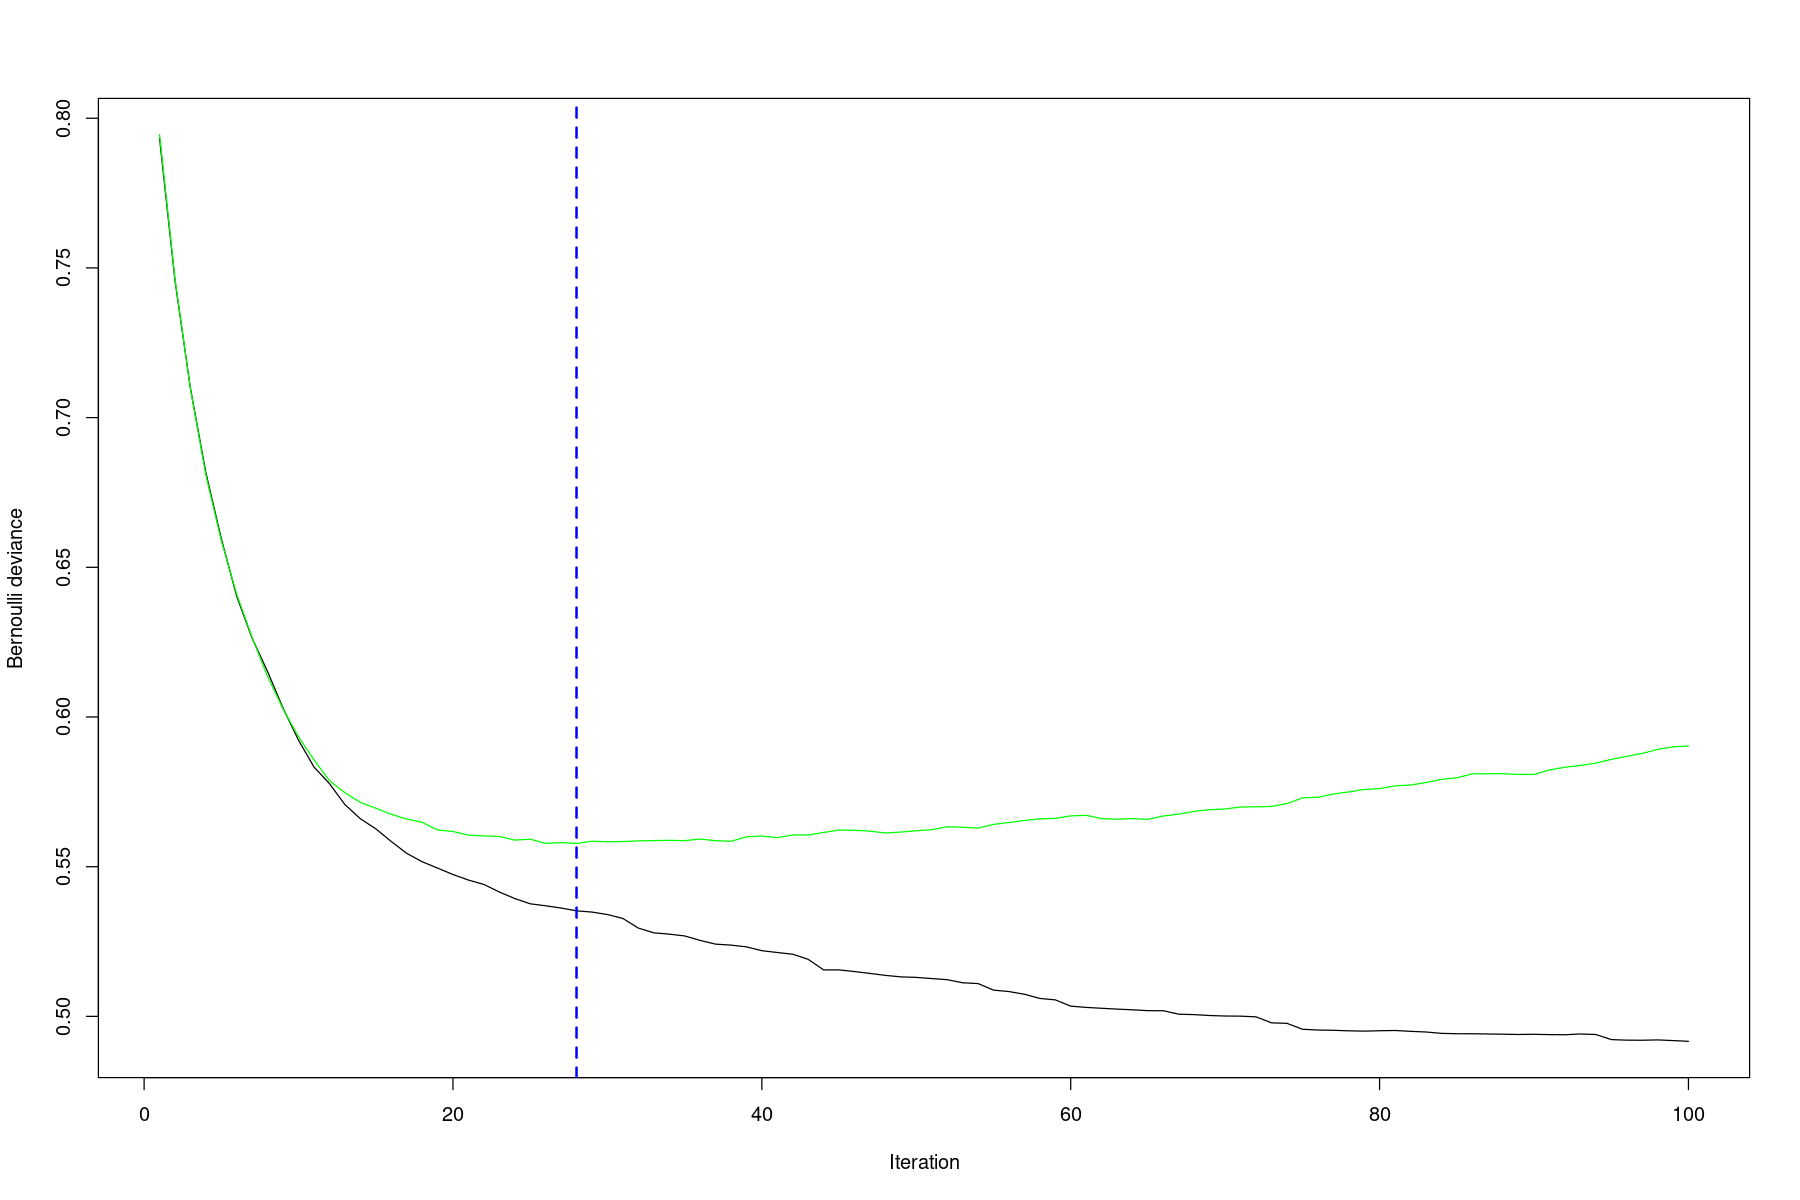

In [14]:
best_fit <- gbm.perf(retention_gbm1, method = "cv")
best_fit

### Predictions
Las predicciones en GB devuelven solo la probabilidad

In [15]:
pred_retention_test <- predict(retention_gbm1, newdata = retention_test_clean, type='response')
head(pred_retention_test)

Using 28 trees...




[1] 0.05742904 0.05742904 0.05742904 0.05742904 0.05742904 0.05742904

### Evaluation
#### Train

In [16]:
data_to_eval = retention_train_clean
pred_retention <- predict(retention_gbm1, newdata = data_to_eval, type='response')

confusionMatrix(data = as.factor(ifelse(pred_retention>0.5, 1, 0)),
                reference = as.factor(data_to_eval$Revenue),
                positive='1',
                mode='prec_recall'
               )

Using 28 trees...




Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 7965  664
         1  373  863
                                          
               Accuracy : 0.8949          
                 95% CI : (0.8887, 0.9009)
    No Information Rate : 0.8452          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5644          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
              Precision : 0.69822         
                 Recall : 0.56516         
                     F1 : 0.62468         
             Prevalence : 0.15479         
         Detection Rate : 0.08748         
   Detection Prevalence : 0.12529         
      Balanced Accuracy : 0.76021         
                                          
       'Positive' Class : 1               
                                          

#### Test

In [17]:
data_to_eval = retention_test_clean
pred_retention <- predict(retention_gbm1, newdata = data_to_eval, type='response')

confusionMatrix(data = as.factor(ifelse(pred_retention>0.5, 1, 0)),
                reference = as.factor(data_to_eval$Revenue),
                positive='1',
                mode='prec_recall'
               )

Using 28 trees...




Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1977  159
         1  107  222
                                          
               Accuracy : 0.8921          
                 95% CI : (0.8792, 0.9041)
    No Information Rate : 0.8454          
    P-Value [Acc > NIR] : 1.222e-11       
                                          
                  Kappa : 0.5627          
                                          
 Mcnemar's Test P-Value : 0.001766        
                                          
              Precision : 0.67477         
                 Recall : 0.58268         
                     F1 : 0.62535         
             Prevalence : 0.15456         
         Detection Rate : 0.09006         
   Detection Prevalence : 0.13347         
      Balanced Accuracy : 0.76567         
                                          
       'Positive' Class : 1               
                                          

# General tuning strategy
A diferencia de Random Forest, GBM tiene una alta variabilidad en las métricas de performance dependiendo de los valores que definamos para el modelo. De esta forma tenemos que tener mayor entendimiento del efecto de cada hiper-parámetro y definir una estrategia más elaborada que en RF. En general un buen plan es:

* Elegir un learning rate (*lr*) alto. Por lo general el valor por defecto es 0.1 pero puede variar entre 0.05-0.3 dependiendo del problema.
* Determina el número óptimo de iteraciones/árboles para ese *lr*.
* Modifica los hiper-parámetros de los árboles
* Explora disminuir el *lr* en búsqueda de pequeñas mejoras
* Si en los pasos anteriores no utilizaste CV entrena con los mejores hiperparametros y usa CV para obtener resultados más robustos.

## Modeling
### GBM model 2

In [18]:
set.seed(42)

retention_gbm2 <- gbm(
  formula = Revenue ~ .,
  data = retention_train_clean,
  distribution = "bernoulli",
  n.trees = 100,
  shrinkage = 0.1,
  interaction.depth = 2,
  n.minobsinnode = 10,
  class.stratify.cv = TRUE,
  cv.folds = 5
)

# Encuentra el numero de arboles que genera el menor error
best <- which.min(retention_gbm2$cv.error)

retention_gbm2$cv.error[best]

[1] 0.5516542

In [19]:
set.seed(42)

retention_gbm3 <- gbm(
  formula = Revenue ~ .,
  data = retention_train_clean,
  distribution = "bernoulli",
  n.trees = 100,
  shrinkage = 0.1,
  interaction.depth = 4,
  n.minobsinnode = 10,
  class.stratify.cv = TRUE,
  cv.folds = 5
)

# Encuentra el numero de arboles que genera el menor error
best <- which.min(retention_gbm3$cv.error)

retention_gbm3$cv.error[best]

[1] 0.547505

In [20]:
set.seed(42)

retention_gbm4 <- gbm(
  formula = Revenue ~ .,
  data = retention_train_clean,
  distribution = "bernoulli",
  n.trees = 100,
  shrinkage = 0.1,
  interaction.depth = 7,
  n.minobsinnode = 10,
  class.stratify.cv = TRUE,
  cv.folds = 5
)

# Encuentra el numero de arboles que genera el menor error
best <- which.min(retention_gbm4$cv.error)

retention_gbm4$cv.error[best]

[1] 0.549264

In [21]:
set.seed(42)

retention_gbm5 <- gbm(
  formula = Revenue ~ .,
  data = retention_train_clean,
  distribution = "bernoulli",
  n.trees = 1000,
  shrinkage = 0.005,
  interaction.depth = 4,
  n.minobsinnode = 10,
  class.stratify.cv = TRUE,
  cv.folds = 5
)

# Encuentra el numero de arboles que genera el menor error
best <- which.min(retention_gbm5$cv.error)

retention_gbm5$cv.error[best]

[1] 0.5416111

### Optimum iteration

[1] 582

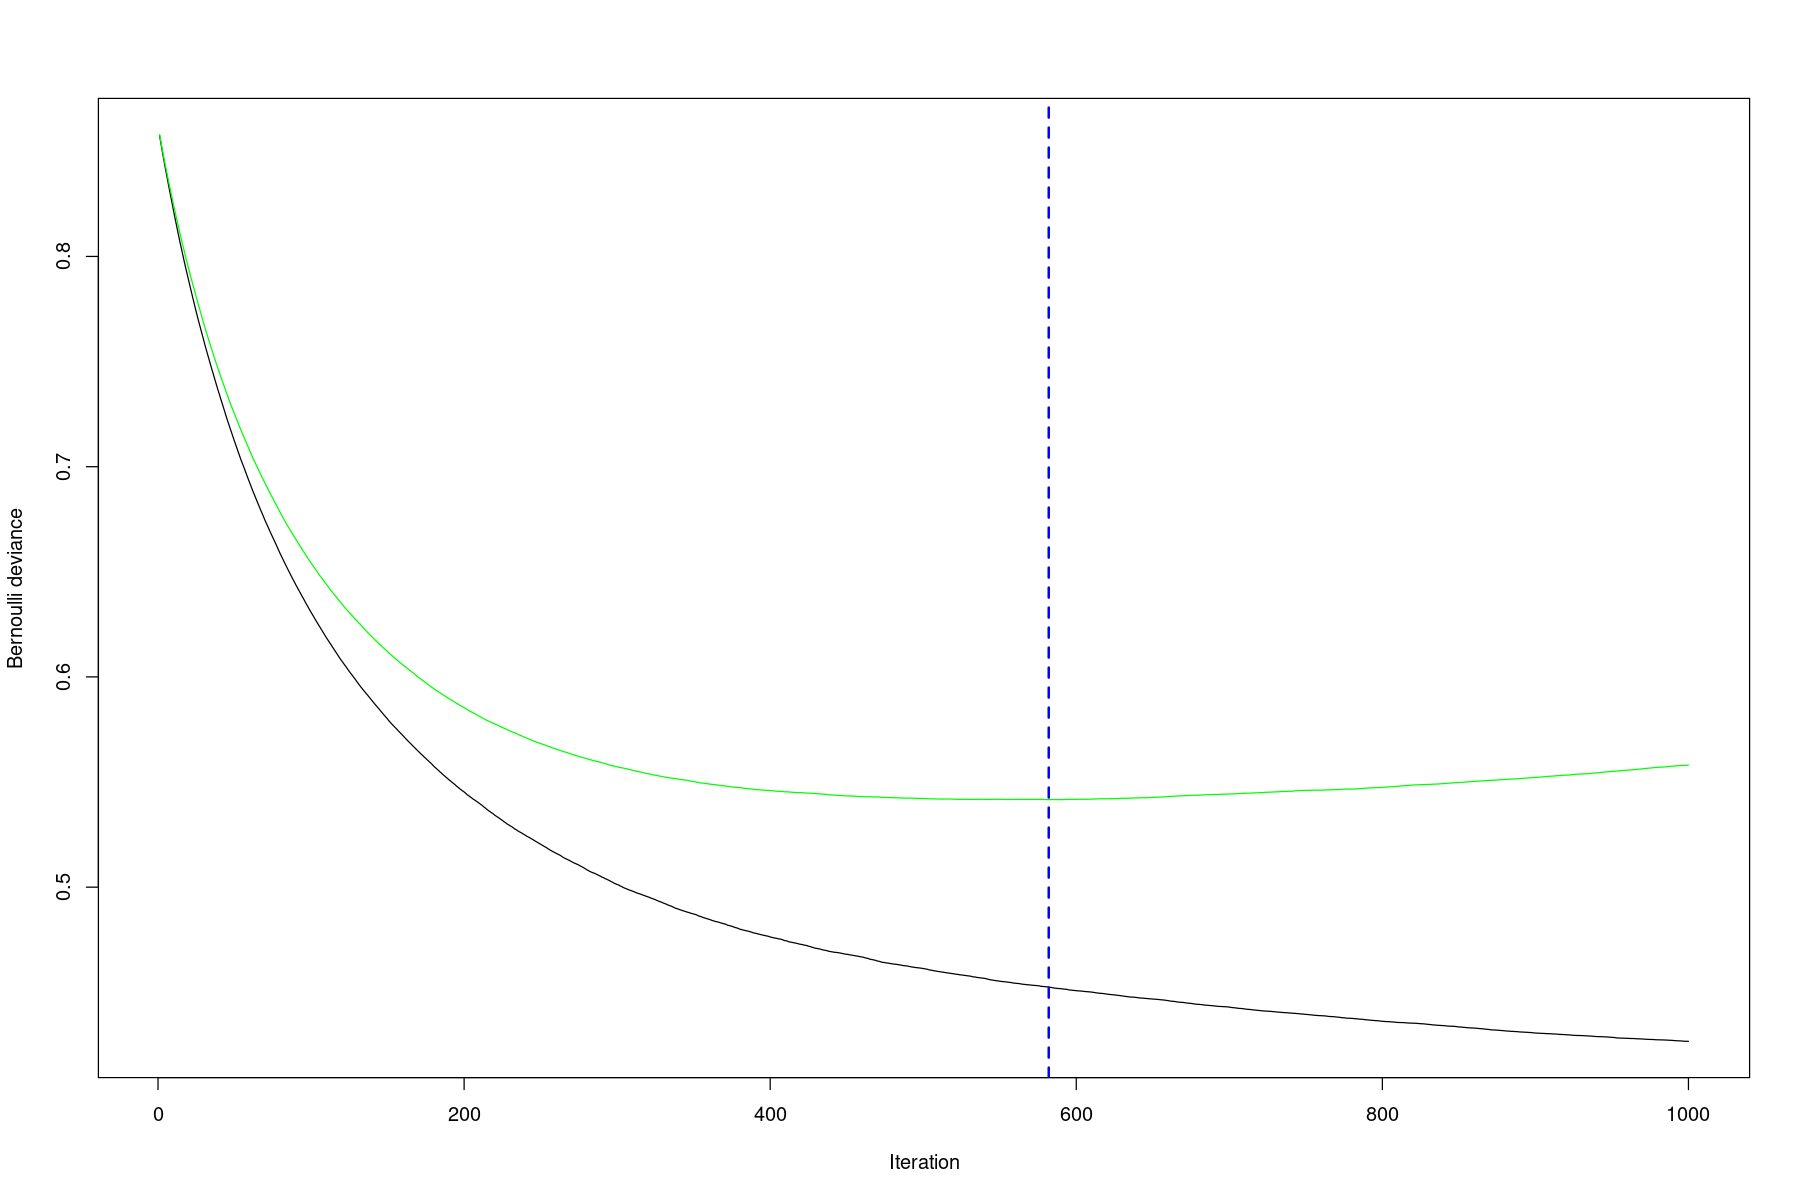

In [22]:
best_fit <- gbm.perf(retention_gbm5, method = "cv")
best_fit

In [23]:
data_to_eval = retention_train_clean
pred_retention <- predict(retention_gbm5, newdata = data_to_eval, type='response')

confusionMatrix(data = as.factor(ifelse(pred_retention>0.5, 1, 0)),
                reference = as.factor(data_to_eval$Revenue),
                positive='1',
                mode='prec_recall'
               )

Using 582 trees...




Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 8084  566
         1  254  961
                                          
               Accuracy : 0.9169          
                 95% CI : (0.9113, 0.9223)
    No Information Rate : 0.8452          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6534          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
              Precision : 0.79095         
                 Recall : 0.62934         
                     F1 : 0.70095         
             Prevalence : 0.15479         
         Detection Rate : 0.09742         
   Detection Prevalence : 0.12316         
      Balanced Accuracy : 0.79944         
                                          
       'Positive' Class : 1               
                                          

In [24]:
data_to_eval = retention_test_clean
pred_retention <- predict(retention_gbm5, newdata = data_to_eval, type='response')

confusionMatrix(data = as.factor(ifelse(pred_retention>0.5, 1, 0)),
                reference = as.factor(data_to_eval$Revenue),
                positive='1',
                mode='prec_recall'
               )

Using 582 trees...




Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1984  158
         1  100  223
                                          
               Accuracy : 0.8953          
                 95% CI : (0.8826, 0.9071)
    No Information Rate : 0.8454          
    P-Value [Acc > NIR] : 3.735e-13       
                                          
                  Kappa : 0.573           
                                          
 Mcnemar's Test P-Value : 0.0003872       
                                          
              Precision : 0.69040         
                 Recall : 0.58530         
                     F1 : 0.63352         
             Prevalence : 0.15456         
         Detection Rate : 0.09047         
   Detection Prevalence : 0.13103         
      Balanced Accuracy : 0.76866         
                                          
       'Positive' Class : 1               
                                          

# Stochastic GBMs
Una de las grandes contribuciones de Breiman (el creador de bagging y RF) fue la idea de introducir muestras aleatorias en en el proceso de entrenamiento del modelo reduciendo la correlación entre los modelos lo que ayuda a mejorar el performance. Estas ideas fueron introducidas también en bagging para reducir el overfitting y ayudar a encontrar el mínimo global del error. Este procedimiento es conocido con *stochastic gradient boosting*.

Algunas de las variaciones de esta mejora son:
1. **Muestreo de las observaciones (sin reemplazo) antes de crear cada árbol** (gbm, xgboost, h20)
2. **Muestreo de las columnas antes de crear cada árbol** (xgboost, h20)
3. **Muestreo de las columnas antes de cada split** de los árboles (xgboost, h20)

Generalmente opción (1) con valores del 50% o menos del conjunto de train pueden tener un efecto positivo en el performance del modelo (0.5-0.8). Por otro lado la opción (2) puede llegar a tener un gran impacto en el performance del modelo dependiendo del dataset que estemos usando, si existe una fuerte multicolinealidad (usar valores bajos) o features ruidosas o poco informáticas (usar valores altos). Finalmente al igual de RF se puede usar un hiper-parámetro como mtry.

En general estos hiperparametros no tienen relación con los otros hiperparametros vistos anteriormente.


## eXtreme Gradient Boosting XGBoost

XGBoost es una implementación de gradient boosting con foco en la optimización distribuida del gradiente, fue diseñada para ser eficiente, flexible y portable en diferentes lenguajes (R, Python, julia, ...). Además de las características que se mencionan arriba sobre stochastic GBM, XGBoost incluye un par ventajas extras:
* **Regularización**: parámetros para controlar el overfitting
* **Early Stop**: permite definir políticas para detener el entrenamiento si no hay mejoras en la métrica de evaluación, reducción el tiempo de entrenamiento.
* **Paralelismo**: A pesar de que la naturaleza de boosting es secuencial, los desarrolladores implementaron maneras de hacer el entrenamiento en paralelo y distribuido (CPU, GPU y Spark)
* **Loss functions**: además de una larga lista de loss function que ya vienen definidas XGBoost permite crear una loss personalizada a las necesidades del problema a solucionar.
* **Continuar el entrenamiento**: se puede guardar el modelo y luego cargar nuevamente este y seguir entrenando sin tener que volver a reentrenar.
* **Base learner**: Además de árboles de decisión se puede usar modelos lineales generalizados.


## hyper-parámetros
### Regularización
* **gamma**: también conocido como *Lagrangian multiplier* es un técnica para controlar la complejidad de los árboles. Gamma específica la reducción mínima de la loss function para que que se genere un split de un node. Cuando este parámetro es usado XGBoost construye el árbol hasta el final y luego hace pruning de los nodos que no cumplen con la condición de gamma. El rango es de $0 \to \infty$, 0 es no aplicar regularización y valores más alto (dependiendo de la loss function que se use) pueden ayudar a reducir el overfitting.

* **alpha**: Regulación del tipo L1 (análoga a Lasso), adicionalmente este genera feature selection por naturaleza lo que ayudará cuando tenemos muchas features en el dataset.
* **lambda**: Regulación del tipo L2 (análoga a Ridge)
### Dropout
Dropout es una técnica para reducir el overfitting, introducido originalmente para redes neuronales, la idea también se implementó en boosting. La idea es construir la secuencia de árboles pero aleatoriamente sacar alguno de ellos en cada iteración (no eliminarlos, solo no considerarlos) con el objetivo de permitir a más árboles generar un impacto sobre el resultado final y reducir el overfitting. Por lo general los primeros árboles son los que tienen el mayor peso y determinan el comportamiento del modelo. Es conocido como DART (Dropout Additive Regression Trees).

### Tuning strategy

La estrategia es similar a la mencionada anteriormente solo que ahora tenemos un par extra de hiper-parámetros que tenemos que tener en cuenta:
* Elige un número alto de iteraciones y prueba el *lr* que mejor resultado te de
* Ajusta los parámetros específicos de los árboles
* Explora las opciones de stochastic GBM
* Si notas diferencias sustanciales entre train y val (usando CV) explora los parámetros de regularización
* Prueba ajusta el *lr* para ver si puedes mejorar el performance


[![Everything Is AWESOME](https://yt-embed.herokuapp.com/embed?v=Vly8xGnNiWs)](https://www.youtube.com/watch?v=Vly8xGnNiWs&feature=emb_title)

[Original Paper](https://arxiv.org/pdf/1603.02754.pdf)

## Prepare data
A diferencia de GBM, XGBoost no es posible definir la clásica fórmula de R, en lugar de ello hay que pasar una matriz con las features y un vector con el target. Adicionalmente solo funciona con valores numéricos por lo que hay que convertir las variables categóricas en numericas (one-hot encoding)

In [25]:
prep_retention2 <- recipe(Revenue ~ ., data = retention_train) %>%
    step_medianimpute(all_of(numerical)) %>% 
    step_string2factor(all_of(categorical)) %>% 
    step_knnimpute(all_of(categorical)) %>% 
    step_dummy(all_of(categorical), one_hot=TRUE) %>% 
    step_mutate(Revenue = as.integer(Revenue)) %>% 
    prep()
    
retention_train_clean2  <-  bake(prep_retention2, retention_train)
retention_test_clean2  <-  bake(prep_retention2, retention_test)

X_train <- as.matrix(retention_train_clean2[setdiff(names(retention_train_clean2), "Revenue")])
Y_train <- retention_train_clean2$Revenue
X_test <- as.matrix(retention_test_clean2[setdiff(names(retention_test_clean2), "Revenue")])
Y_test <- retention_test_clean2$Revenue

## Base model

La forma más simple de usar XGBoost es usando la función `xgboost` y darle algunos parámetros para el entrenamiento y ver como nos da el resultado.

**Parámetros Generales**
* **booster**:
  * `gbtree` Por defecto
  * `gblinear`
* **nthread**: Número de CPU que usará en el entrenamiento
  * Por defecto usa todos los CPU disponibles
 
**Parámetros de booster**
* **eta**: Learning rate / shrinkage.
  * por defecto 0.3
  * valor finales pueden ser cercanos a 0.01-0.2
* **max_depth**: máxima profundidad de cada árbol.
  * por defecto 6
* **min_child_weight**: suma de los pesos de las observaciones en una hoja.
  * Por defecto 1
* **subsample**: muestreo sin reemplazo con el que se entrena cada nuevo árbol.
  * por defecto 1
  * rango de valores entre 0.5 y 1
* **colsample_bytree**: Porcentaje de columnas consideradas para el entrenamiento de cada modelo.
  * por defecto 1
  * rango de valores entre 0.5 y 1
* **colsample_bylevel**: Porcentaje de columnas consideradas en cada split, en general es suficiente con colsample_bytree.
  * por defecto 1
* **scale_pos_weight**: En caso de dataset muy desbalanceados se puede cambiar el peso de las observaciones para ayudar a la convergencia del óptimo.
  * por defecto 0

**Learning Task**
* **objective**:
  * `binary:logistic` logistic regression para problemas de clasificación binaria (sólo probabilidad)
  * `binary:hinge` hinge loss para clasificación binaria. Retorna valores 0 o 1 en lugar de la probabilidad.
* **eval_metric**: [documentation](https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters)
  * `logloss`
  * `mlogloss`
  * `error` (threshold = 0.5)
  * `auc`
  * `aucpr`
  * `rmse`
  * `mae`

### Model 1

[1] "min train error -> 0.022605"

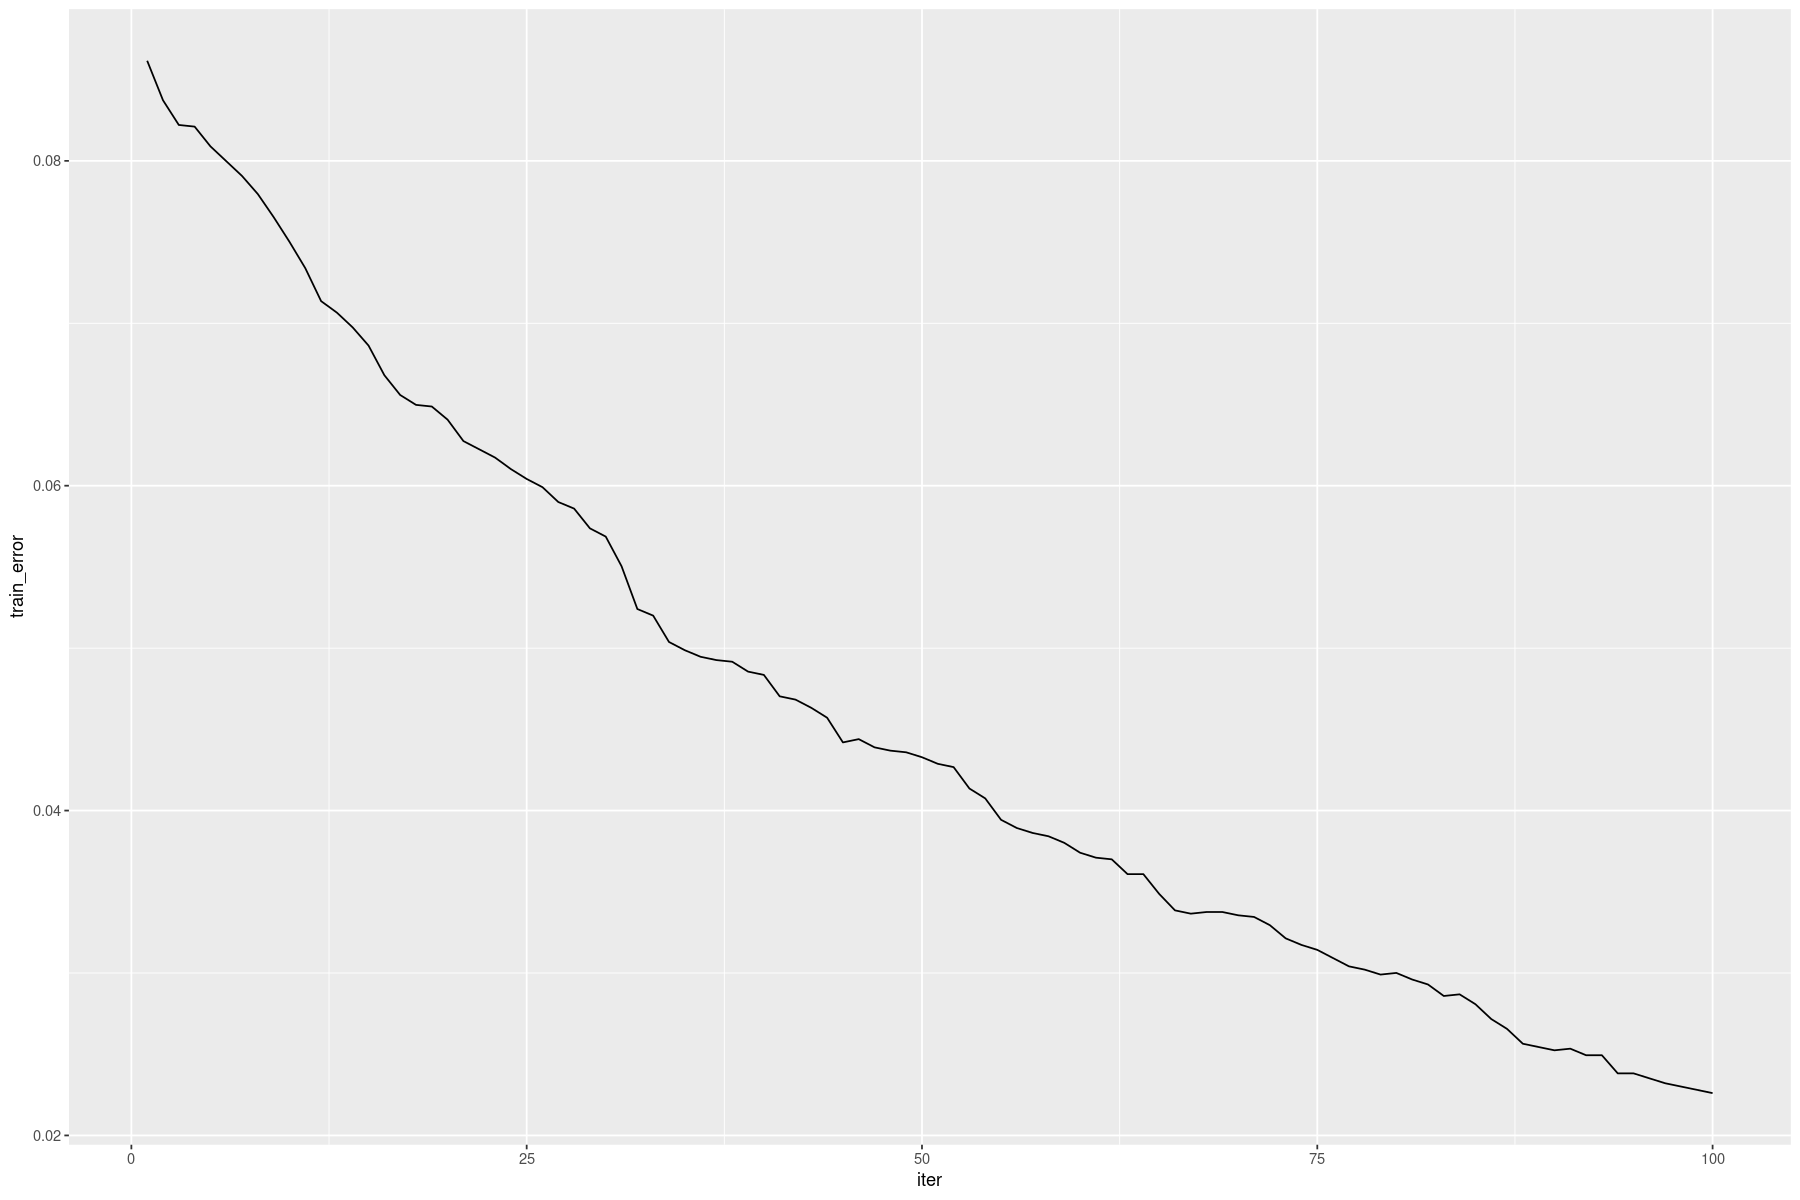

In [26]:
set.seed(42)

params <- list(
  booster = "gbtree",
  objective = "binary:logistic",
  eta = 0.3,
  max_depth = 6,
  min_child_weight = 1,
  subsample = 1,
  colsample_bytree = 1
)

retention_xgb_basic1 <- xgboost(
  params = params,
  data = X_train,
  label = Y_train,
  nrounds = 100,
  verbose = 0
)

paste('min train error ->', min(retention_xgb_basic1$evaluation_log$train_error))

retention_xgb_basic1$evaluation_log %>% 
    ggplot(aes(iter, train_error)) + geom_line()

In [27]:
retention_xgb_basic1$params

$booster
[1] "gbtree"

$objective
[1] "binary:logistic"

$eta
[1] 0.3

$max_depth
[1] 6

$min_child_weight
[1] 1

$subsample
[1] 1

$colsample_bytree
[1] 1

$validate_parameters
[1] TRUE

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



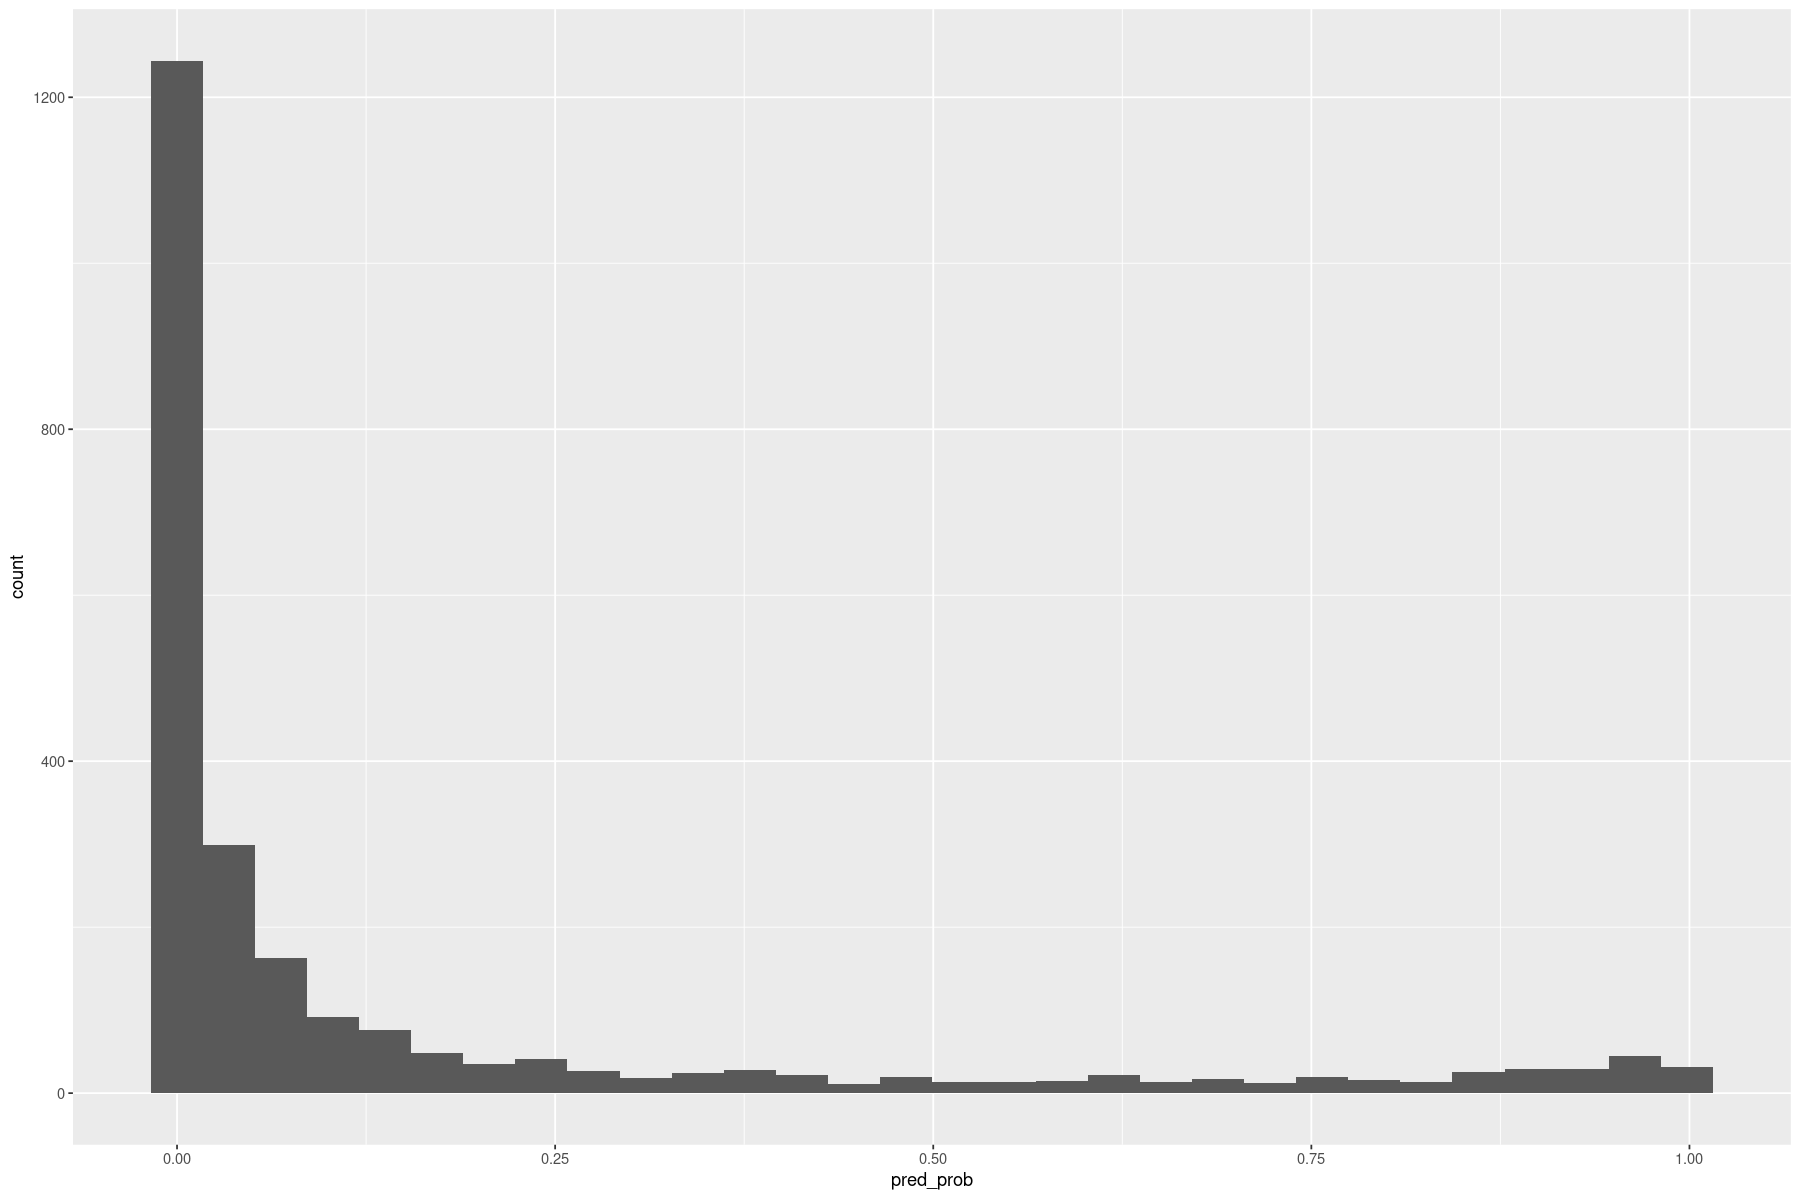

In [28]:
result_basic1 <- tibble(pred_prob = predict(retention_xgb_basic1, newdata=X_test),
                        pred = ifelse(pred_prob>0.5, 1, 0),
                        obs = Y_test
                       )
result_basic1 %>% 
    ggplot(aes(pred_prob)) + geom_histogram()

### Model 2

[1] "min train error -> 0"

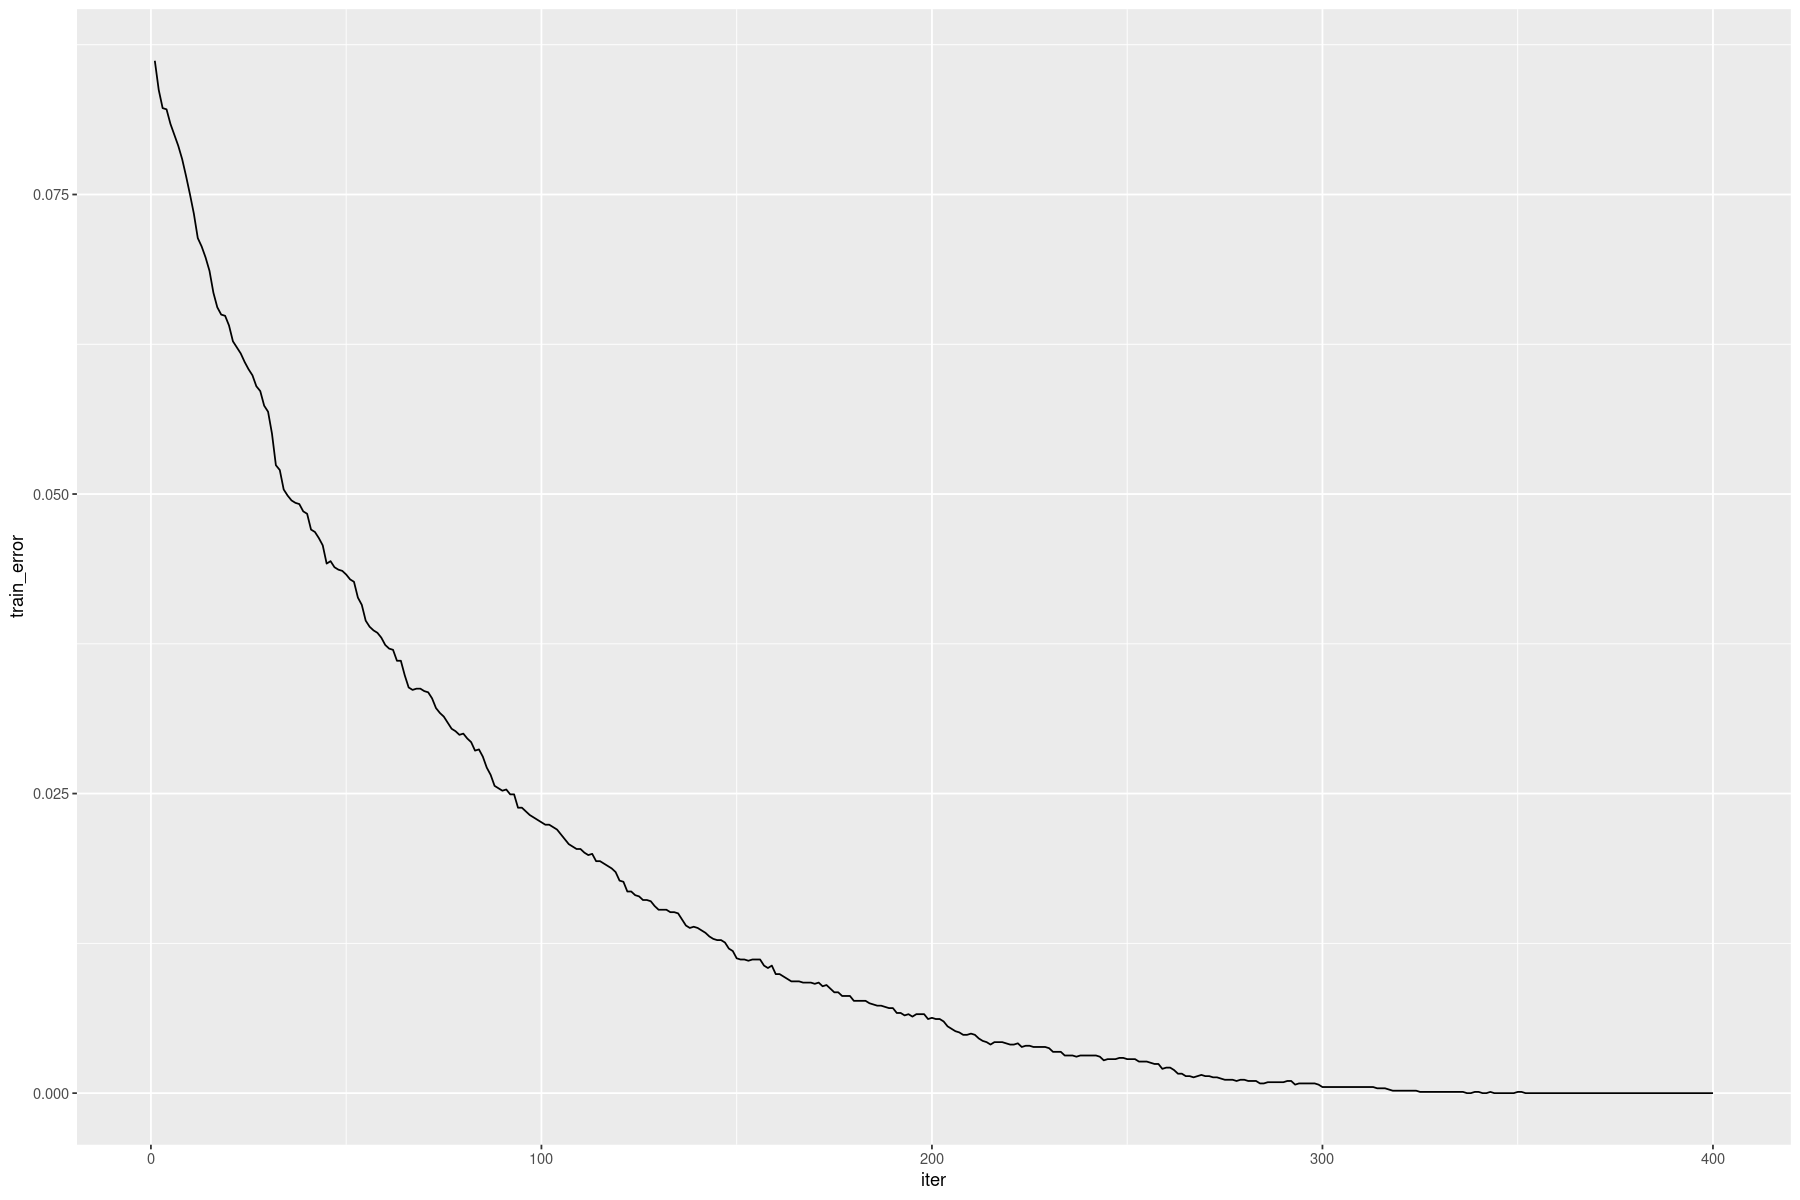

In [29]:
set.seed(42)

params <- list(
  booster = "gbtree",
  objective = "binary:logistic",
  eta = 0.3,
  max_depth = 6,
  min_child_weight = 1,
  subsample = 1,
  colsample_bytree = 1
)

retention_xgb_basic2 <- xgboost(
  params = params,
  data = X_train,
  label = Y_train,
  nrounds = 400,
  verbose = 0
  
)

paste('min train error ->', min(retention_xgb_basic2$evaluation_log$train_error))

retention_xgb_basic2$evaluation_log %>% 
    ggplot(aes(iter, train_error)) + geom_line()

### CV

XGBoost tiene otras funciones que nos permiten tener mayor control del proceso de entrenamiento y evaluación de este, uno de estos métodos es `xgb.cv` y `xgb.train`. Adicionalmente podemos incluir algunas métricas para ver la evolución de esa métrica en cada iteración.

#### Hiper-prametros por defecto 


In [30]:
set.seed(42)

params <- list(
  booster = "gbtree",
  objective = "binary:logistic",
  eta = 0.3,
  max_depth = 6,
  min_child_weight = 1,
  subsample = 1,
  colsample_bytree = 1,
  eval_metric = 'auc',
  eval_metric = 'error',
  eval_metric = 'logloss'
)

retention_xgb_cv1 <- xgb.cv(
  data = X_train,
  label = Y_train,
  nrounds = 400,
  nfold = 5,
  params = params,
  stratified = TRUE,
  verbose = 0
)  
paste('min train error ->', min(retention_xgb_cv1$evaluation_log$train_error_mean))
paste('min test error ->', min(retention_xgb_cv1$evaluation_log$test_error_mean))


[1] "min train error -> 0"

[1] "min test error -> 0.0984284"

In [31]:
retention_xgb_cv1$evaluation_log %>% 
    tail()

iter,train_auc_mean,train_auc_std,train_error_mean,train_error_std,train_logloss_mean,train_logloss_std,test_auc_mean,test_auc_std,test_error_mean,test_error_std,test_logloss_mean,test_logloss_std
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
395,1,0,0,0,0.0126756,0.0004832646,0.9147812,0.006334809,0.1073482,0.002861884,0.3332082,0.01206695
396,1,0,0,0,0.0126274,0.0004861011,0.9147762,0.006332170,0.1071456,0.002813360,0.3333384,0.01200912
397,1,0,0,0,0.0125846,0.0004967392,0.9147504,0.006287294,0.1073482,0.002791030,0.3335682,0.01199566
398,1,0,0,0,0.0125422,0.0004986435,0.9146978,0.006223719,0.1074496,0.002874526,0.3338636,0.01196127
399,1,0,0,0,0.0125080,0.0004938372,0.9147112,0.006140908,0.1076524,0.002645610,0.3340016,0.01175314
400,1,0,0,0,0.0124676,0.0004896642,0.9146796,0.006203798,0.1075510,0.002790950,0.3341064,0.01183310


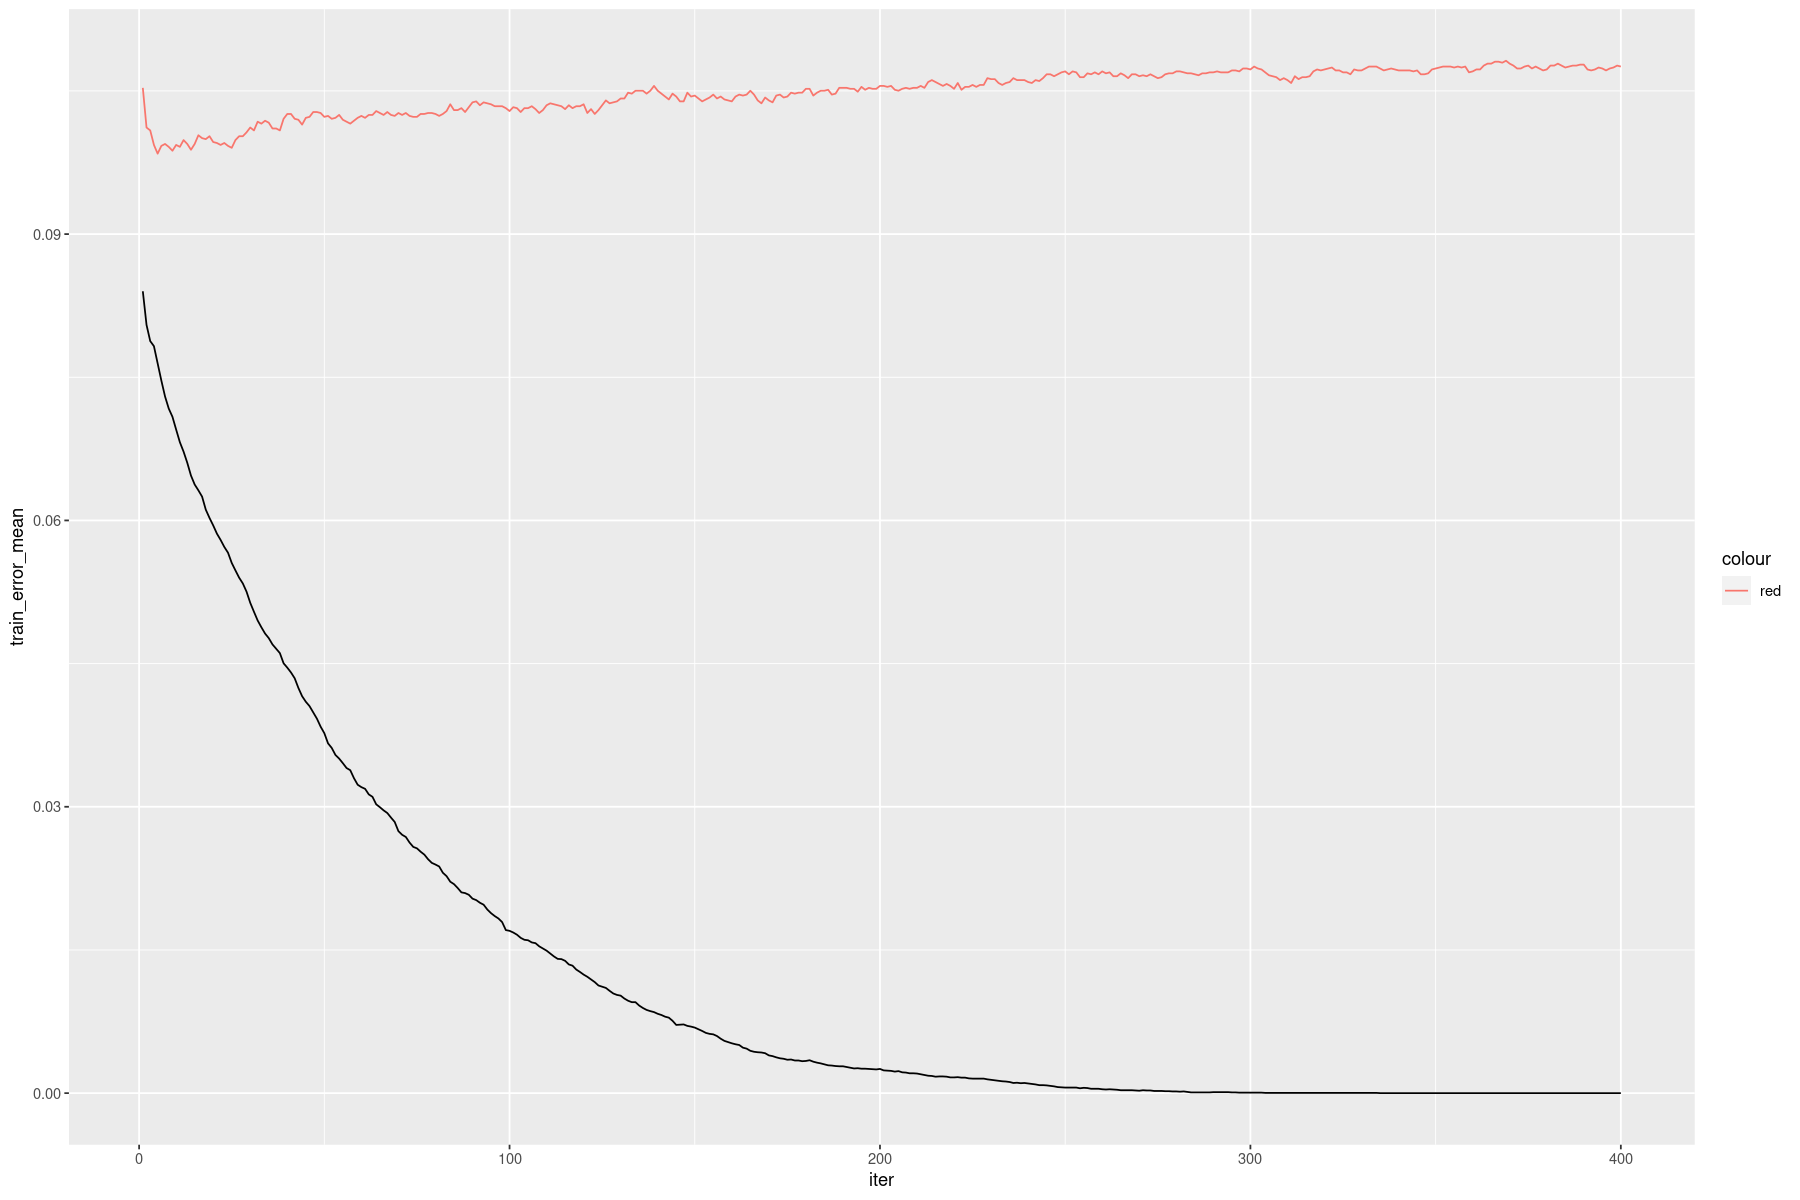

In [32]:
retention_xgb_cv1$evaluation_log %>% 
    ggplot(aes(iter, train_error_mean)) +
        geom_line() + 
        geom_line(aes(iter, test_error_mean, color='red'))

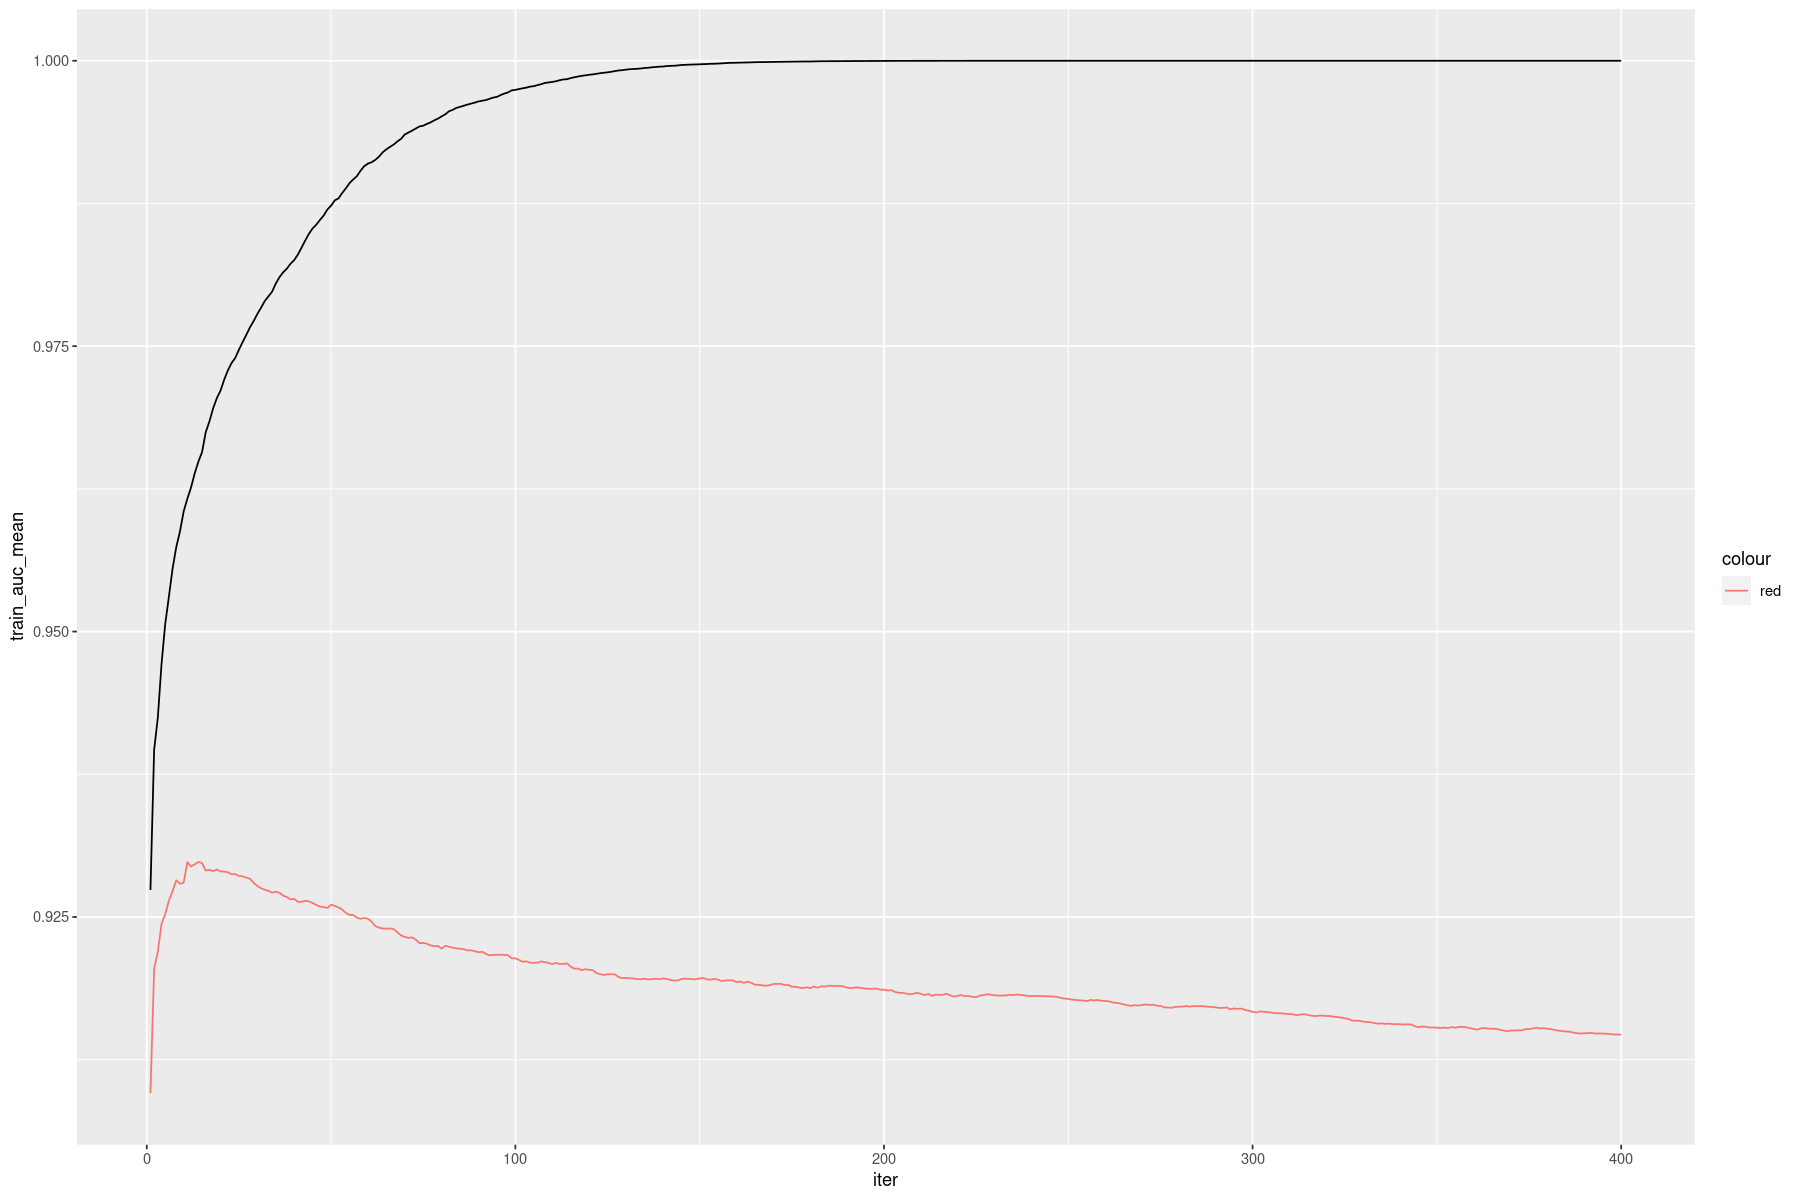

In [33]:
retention_xgb_cv1$evaluation_log %>% 
    ggplot(aes(iter, train_auc_mean)) +
        geom_line() + 
        geom_line(aes(iter, test_auc_mean, color='red'))

#### Hiper-parámetros por defecto + cambios en max_depth=3
Adicionalmente agregamos la opción `Early stop` para detener el entrenamiento si no vemos mejoras en el conjunto de validación


[1] "min train error -> 0.0715408"

[1] "min val error -> 0.0963006"

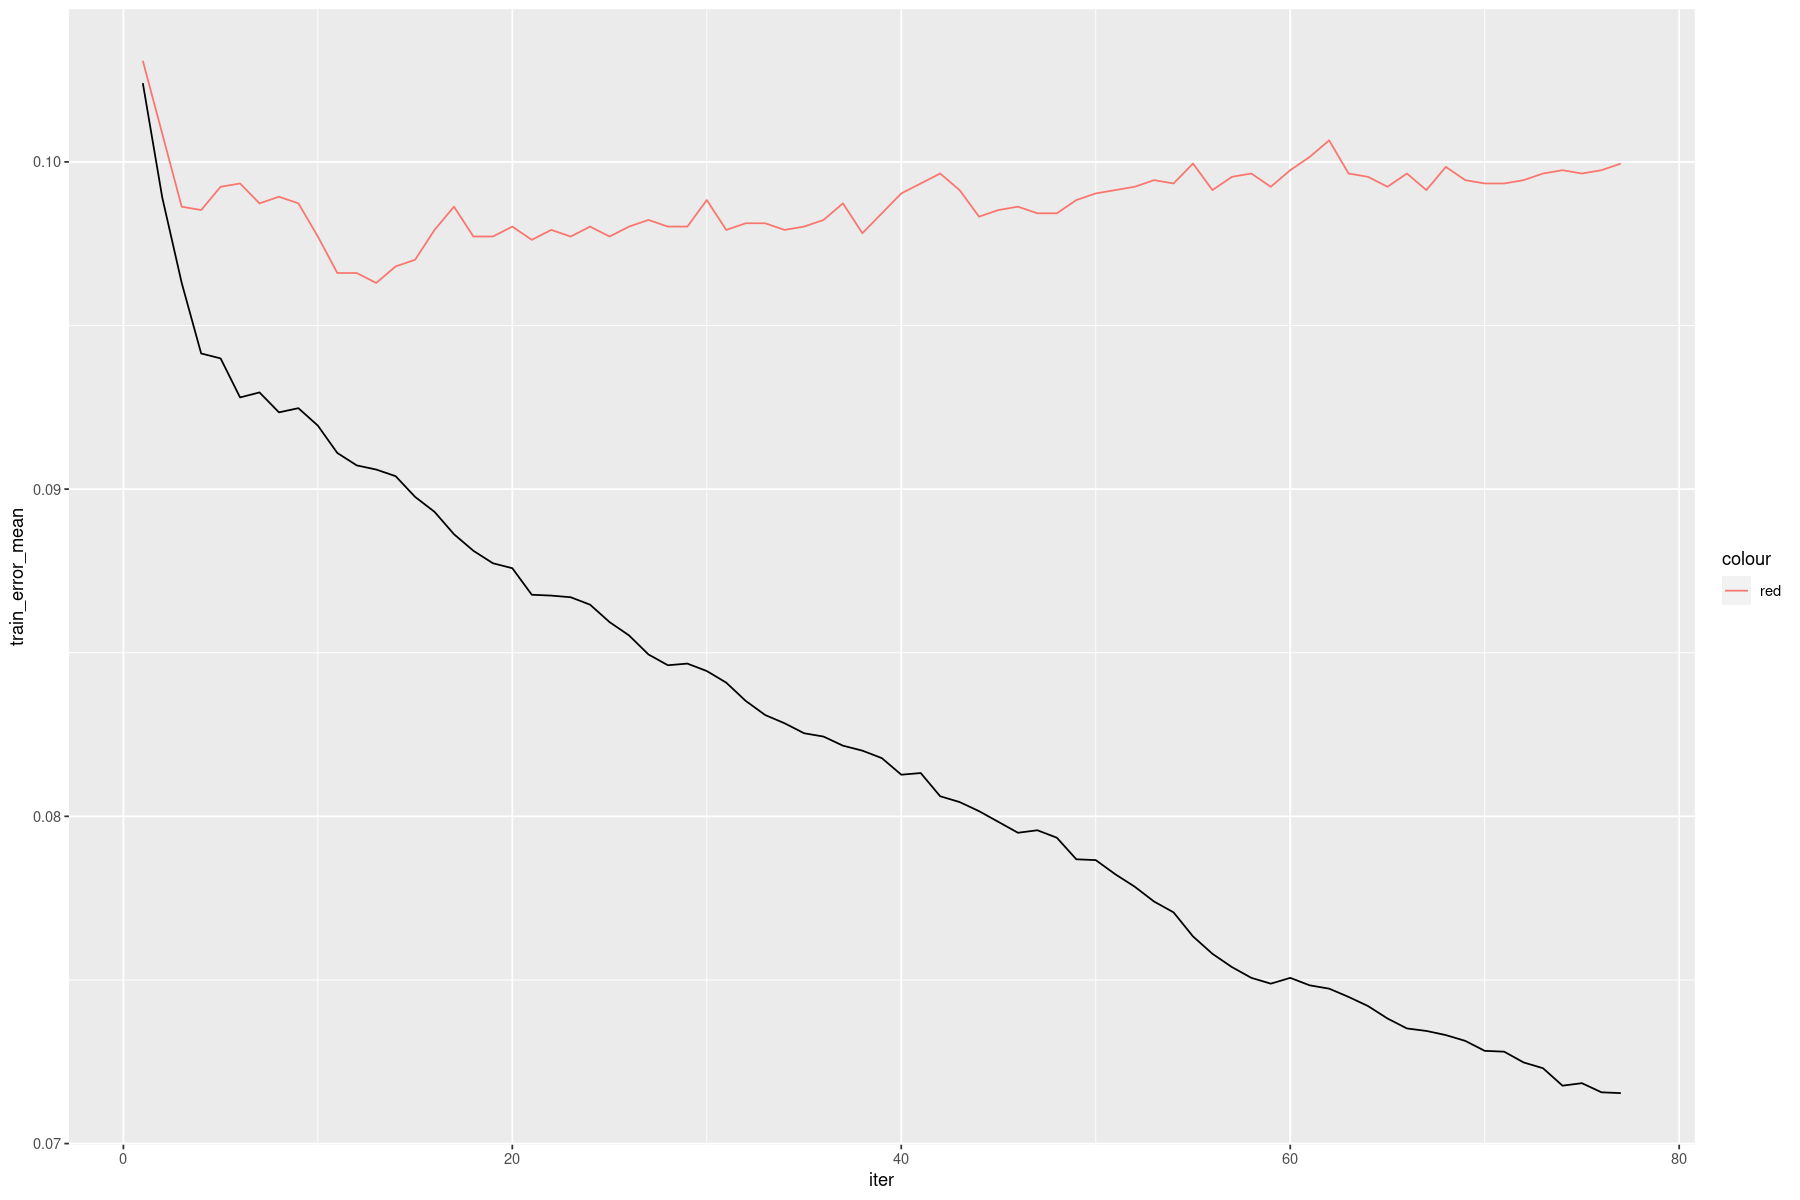

In [34]:
# Valores por defecto
set.seed(42)

params <- list(
  booster = "gbtree",
  objective = "binary:logistic",
  eta = 0.3,
  max_depth = 3,
  min_child_weight = 1,
  subsample = 1,
  colsample_bytree = 1,
  eval_metric = 'error',
  eval_metric = 'logloss'
)

retention_xgb_cv2 <- xgb.cv(
  data = X_train,
  label = Y_train,
  nrounds = 400,
  nfold = 5,
  params = params,
  stratified = TRUE,
  early_stopping_rounds = 50,
  verbose = 0
)  

paste('min train error ->', min(retention_xgb_cv2$evaluation_log$train_error_mean))
paste('min val error ->', min(retention_xgb_cv2$evaluation_log$test_error_mean))

retention_xgb_cv2$evaluation_log %>% 
    ggplot(aes(iter, train_error_mean)) +
        geom_line() + 
        geom_line(aes(iter, test_error_mean, color='red'))

#### Hiper-parámetros por defecto + cambios en max_depth=3 + subsample = 0.5

[1] "min train error -> 0.0741004"

[1] "min val error -> 0.0958954"

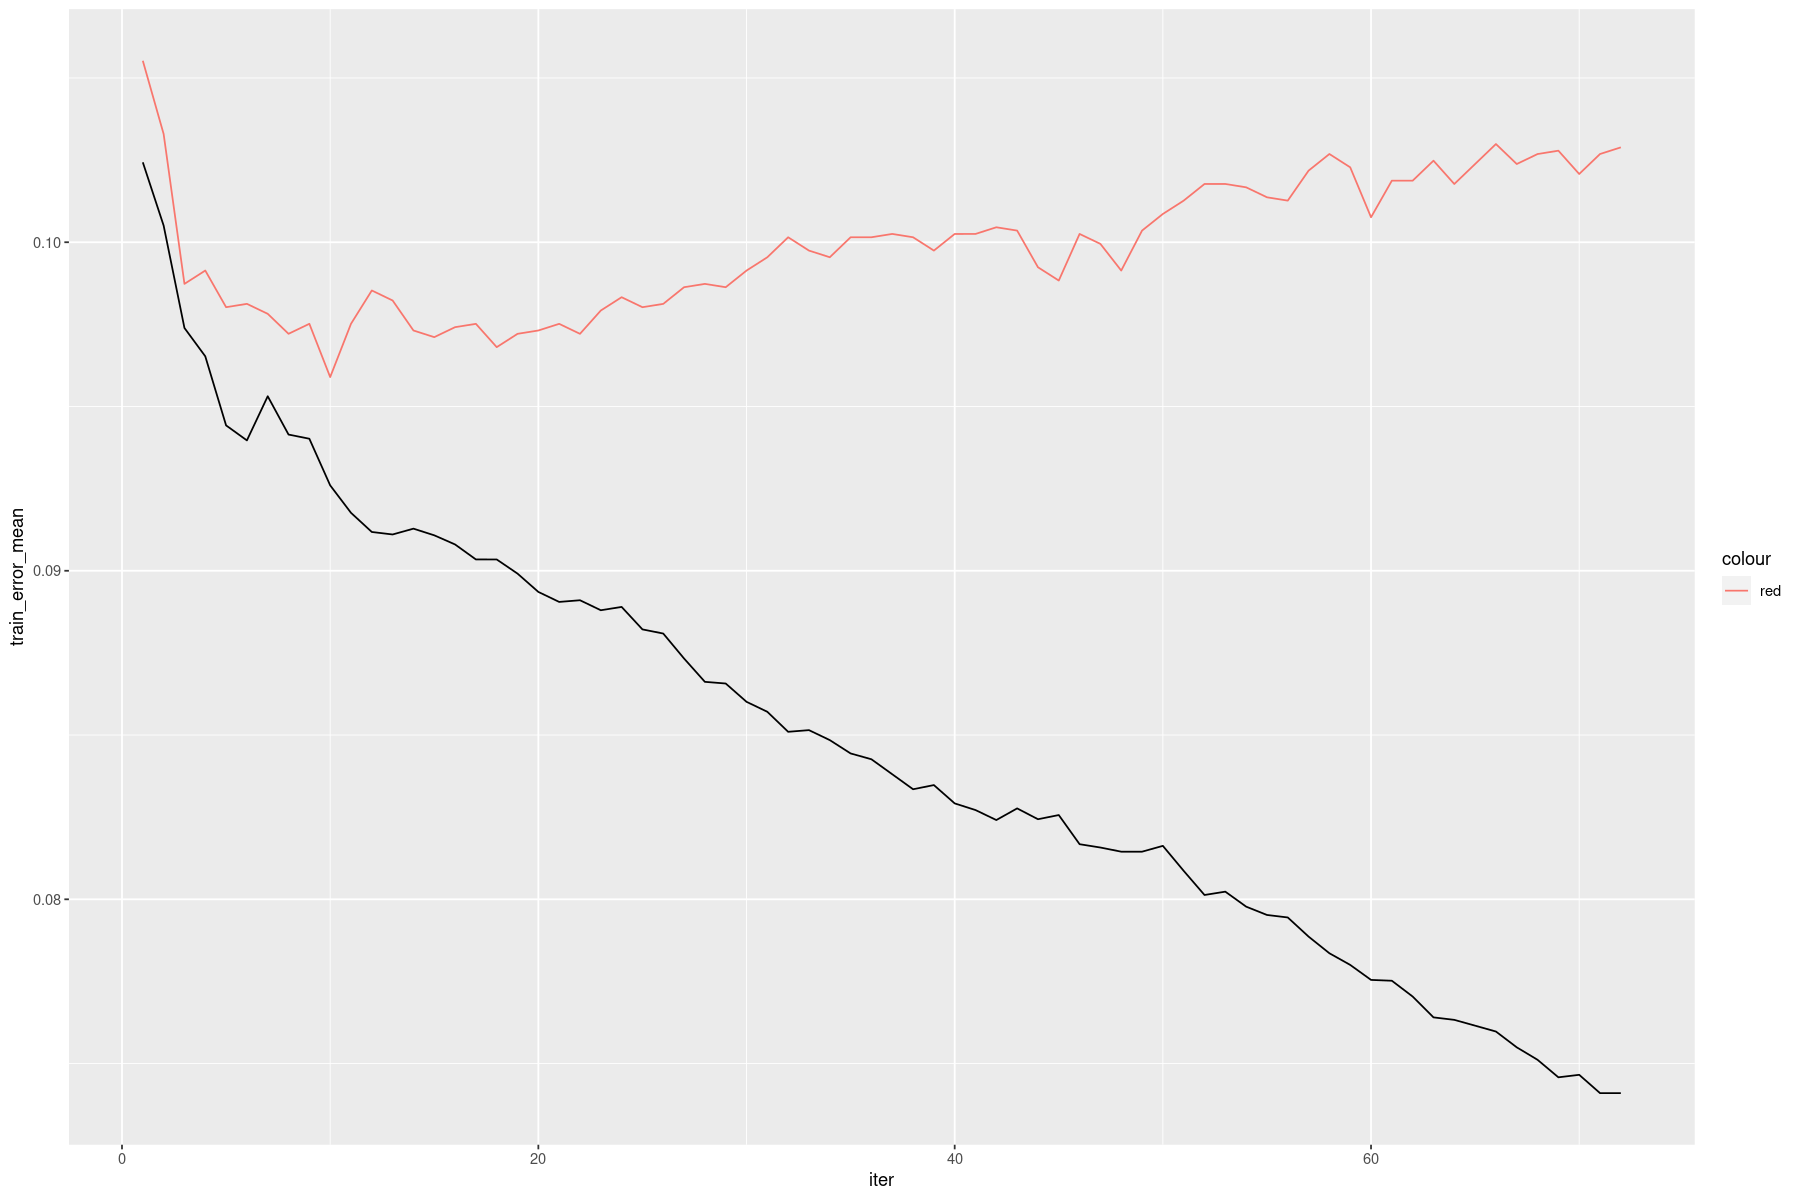

In [35]:
set.seed(42)

params <- list(
  booster = "gbtree",
  objective = "binary:logistic",
  eta = 0.3,
  max_depth = 3,
  min_child_weight = 1,
  subsample = 0.5,
  colsample_bytree = 1,
  eval_metric = 'error',
  eval_metric = 'logloss'
)

retention_xgb_cv3 <- xgb.cv(
  data = X_train,
  label = Y_train,
  nrounds = 400,
  nfold = 5,
  params = params,
  stratified = TRUE,
  early_stopping_rounds = 50,
  verbose = 0
)  

paste('min train error ->', min(retention_xgb_cv3$evaluation_log$train_error_mean))
paste('min val error ->', min(retention_xgb_cv3$evaluation_log$test_error_mean))

retention_xgb_cv3$evaluation_log %>% 
    ggplot(aes(iter, train_error_mean)) +
        geom_line() + 
        geom_line(aes(iter, test_error_mean, color='red'))

#### Hiper-parámetros por defecto + cambios en max_depth=3 + subsample = 0.5 + colsample_bytree = 0.8

[1] "min train error -> 0.0738468"

[1] "min val error -> 0.0984288"

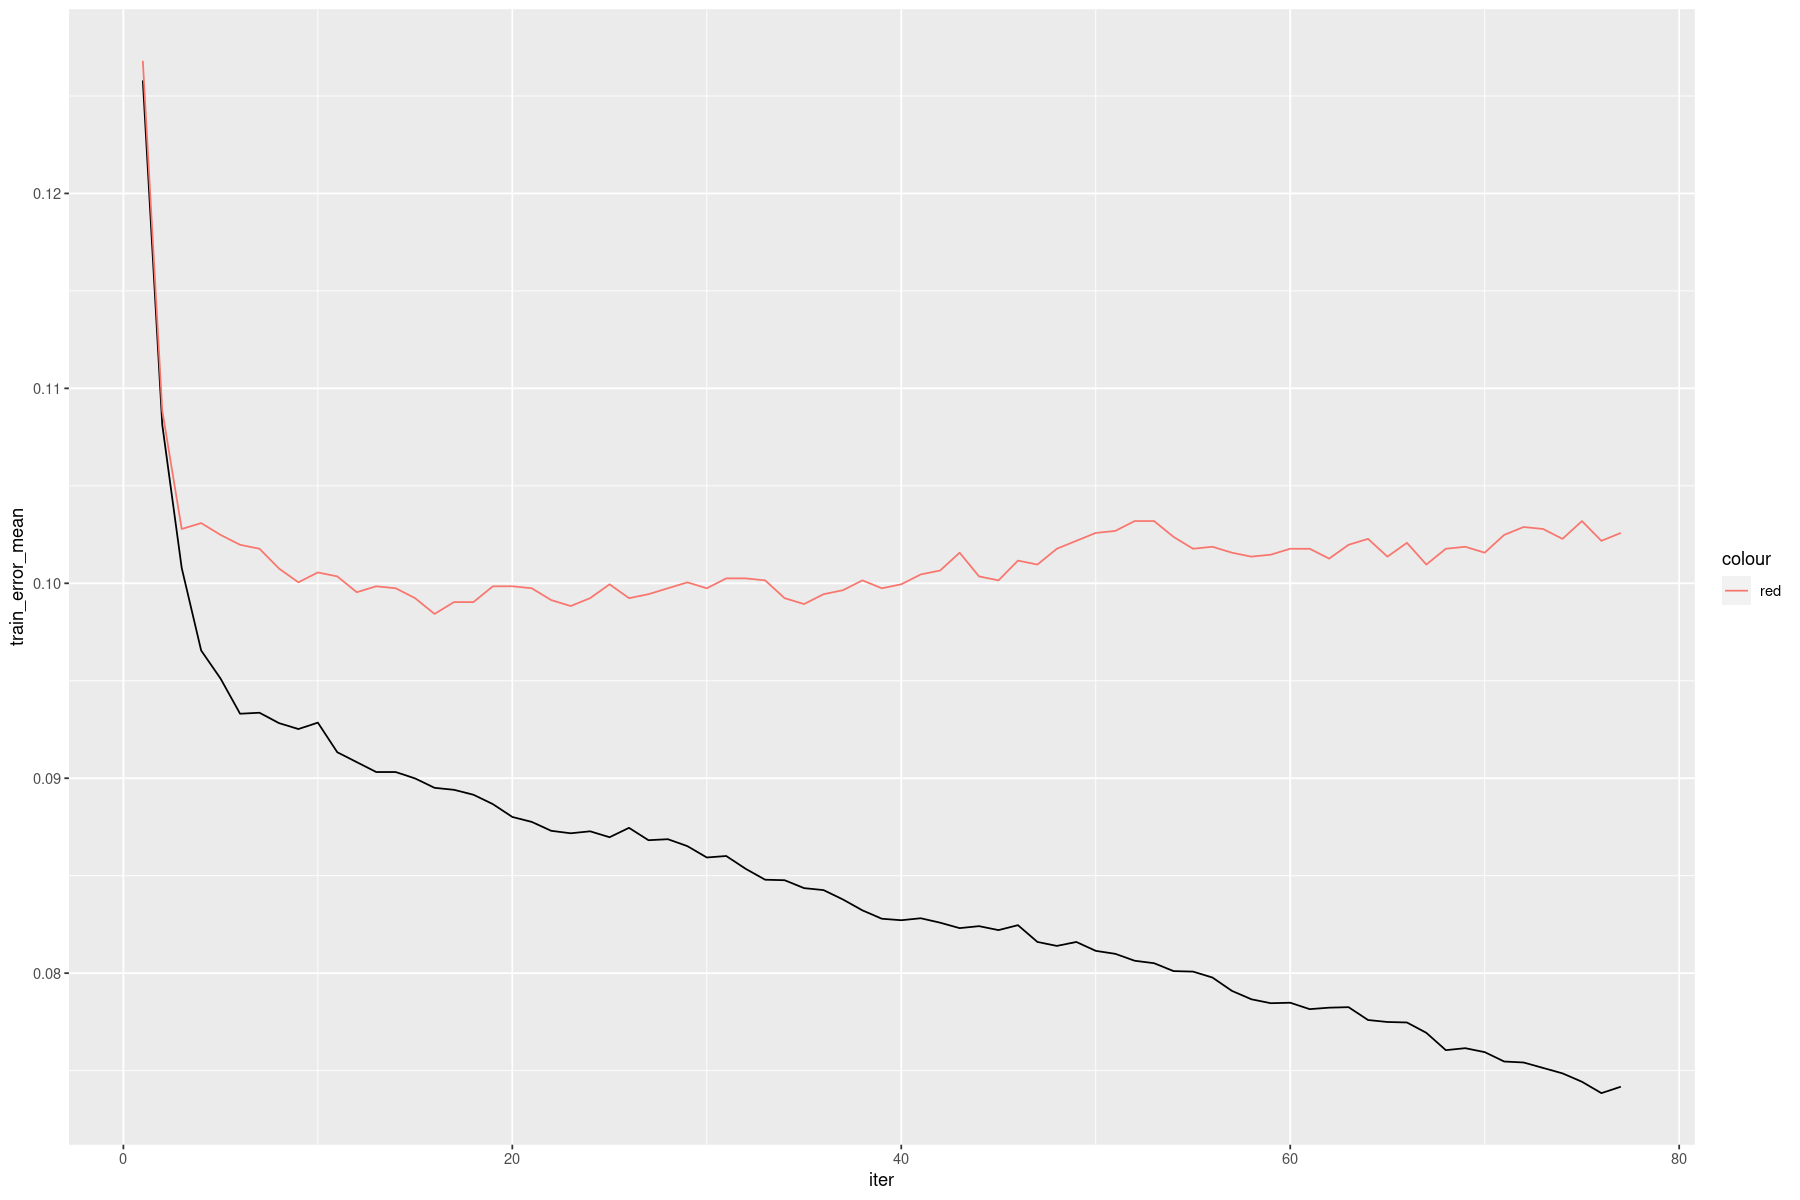

In [36]:
set.seed(42)

params <- list(
  booster = "gbtree",
  objective = "binary:logistic",
  eta = 0.3,
  max_depth = 3,
  min_child_weight = 1,
  subsample = 0.5,
  colsample_bytree = 0.8,
  eval_metric = 'error',
  eval_metric = 'logloss'
)

retention_xgb_cv4 <- xgb.cv(
  data = X_train,
  label = Y_train,
  nrounds = 400,
  nfold = 5,
  params = params,
  stratified = TRUE,
  early_stopping_rounds = 50,
  verbose = 0
)  

paste('min train error ->', min(retention_xgb_cv4$evaluation_log$train_error_mean))
paste('min val error ->', min(retention_xgb_cv4$evaluation_log$test_error_mean))

retention_xgb_cv4$evaluation_log %>% 
    ggplot(aes(iter, train_error_mean)) +
        geom_line() + 
        geom_line(aes(iter, test_error_mean, color='red'))

#### Hiper-parámetros por defecto + cambios en max_depth=3 + subsample = 0.5 + colsample_bytree = 0.8 + gamma=10

[1] "min train error -> 0.0885198"

[1] "min val error -> 0.0984282"

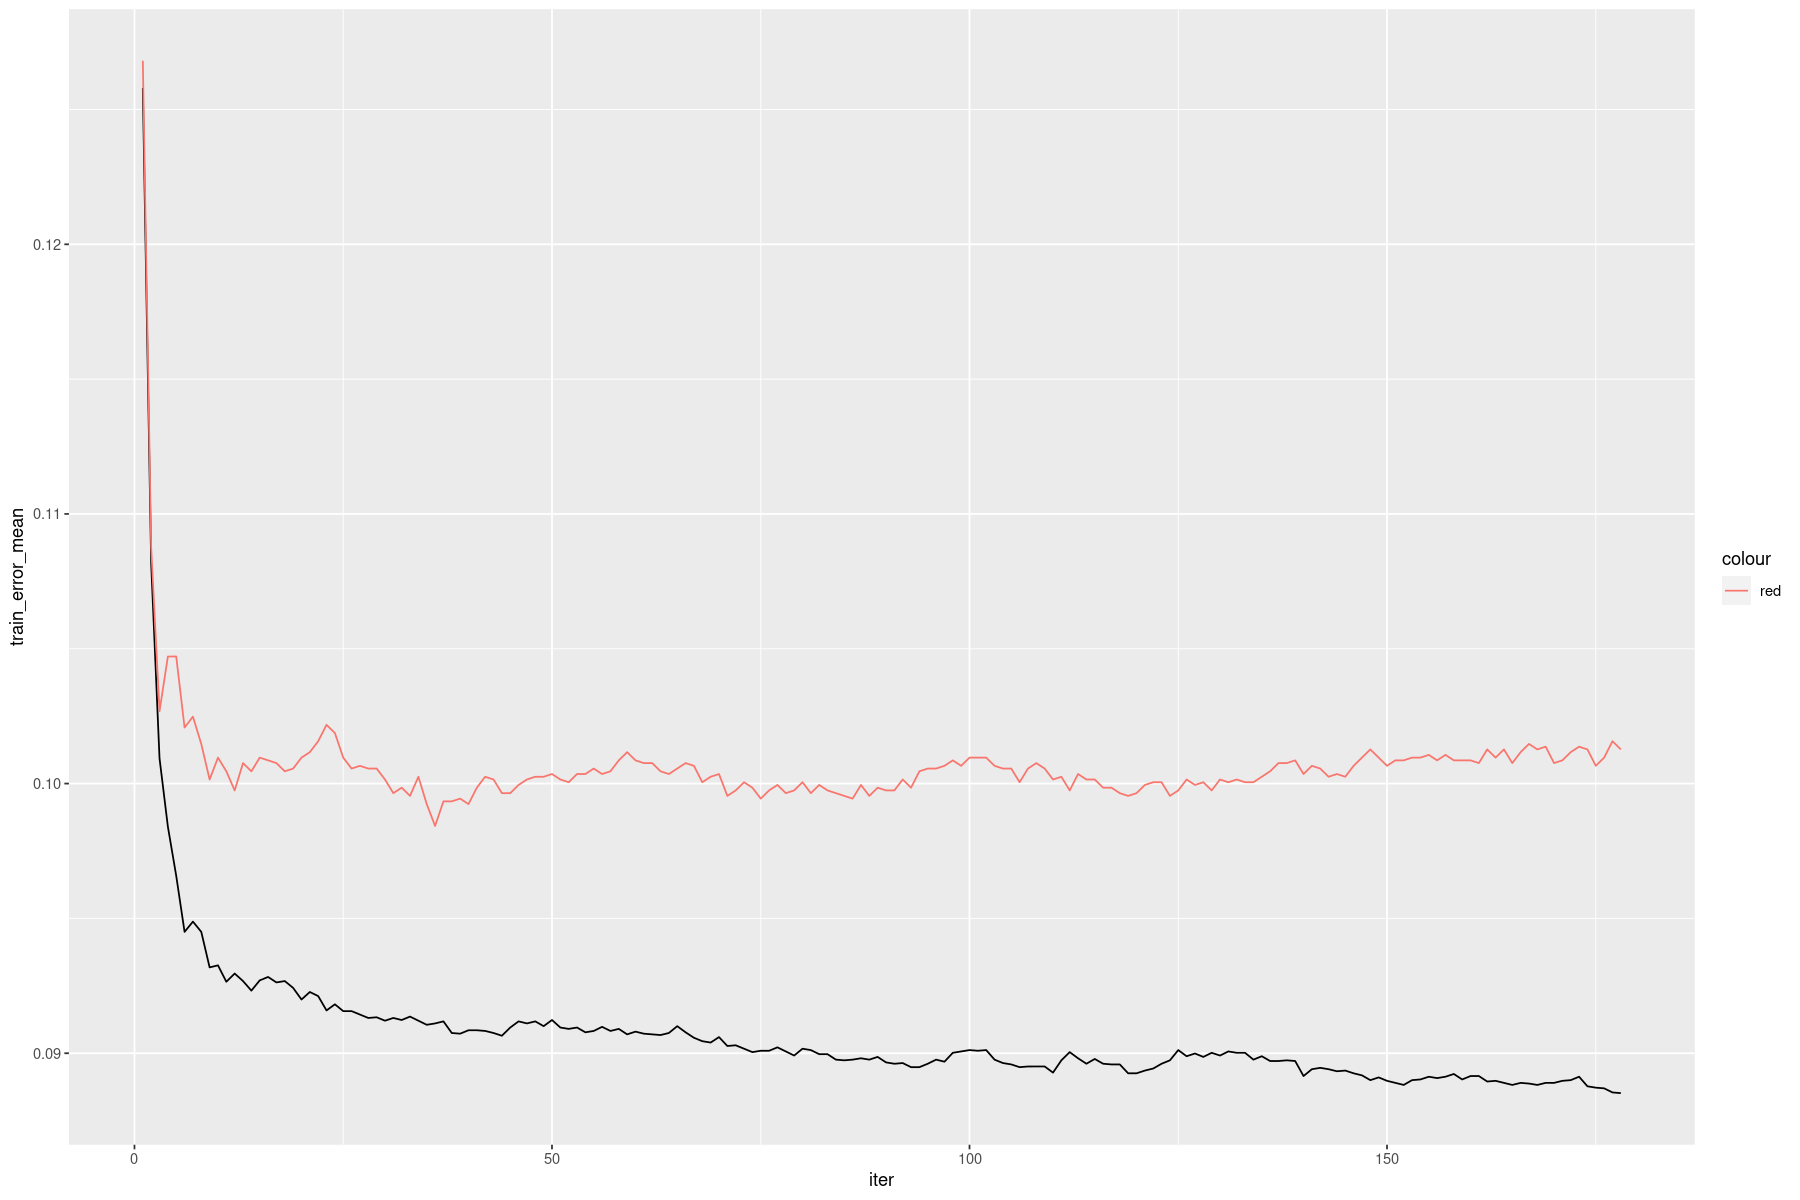

In [37]:
set.seed(42)

params <- list(
  booster = "gbtree",
  objective = "binary:logistic",
  eta = 0.3,
  max_depth = 3,
  min_child_weight = 1,
  subsample = 0.5,
  colsample_bytree = 0.8,
  gamma=10,
  eval_metric = 'error',
  eval_metric = 'logloss'
)

retention_xgb_cv5 <- xgb.cv(
  data = X_train,
  label = Y_train,
  nrounds = 400,
  nfold = 5,
  params = params,
  stratified = TRUE,
  early_stopping_rounds = 50,
  verbose = 0
)  

paste('min train error ->', min(retention_xgb_cv5$evaluation_log$train_error_mean))
paste('min val error ->', min(retention_xgb_cv5$evaluation_log$test_error_mean))

retention_xgb_cv5$evaluation_log %>% 
    ggplot(aes(iter, train_error_mean)) +
        geom_line() + 
        geom_line(aes(iter, test_error_mean, color='red'))

#### Hiper-parámetros por defecto + cambios en max_depth=3 + subsample = 0.8 + colsample_bytree = 0.5 + gamma=10

[1] "min train error -> 0.0900658"

[1] "min val error -> 0.0962994"

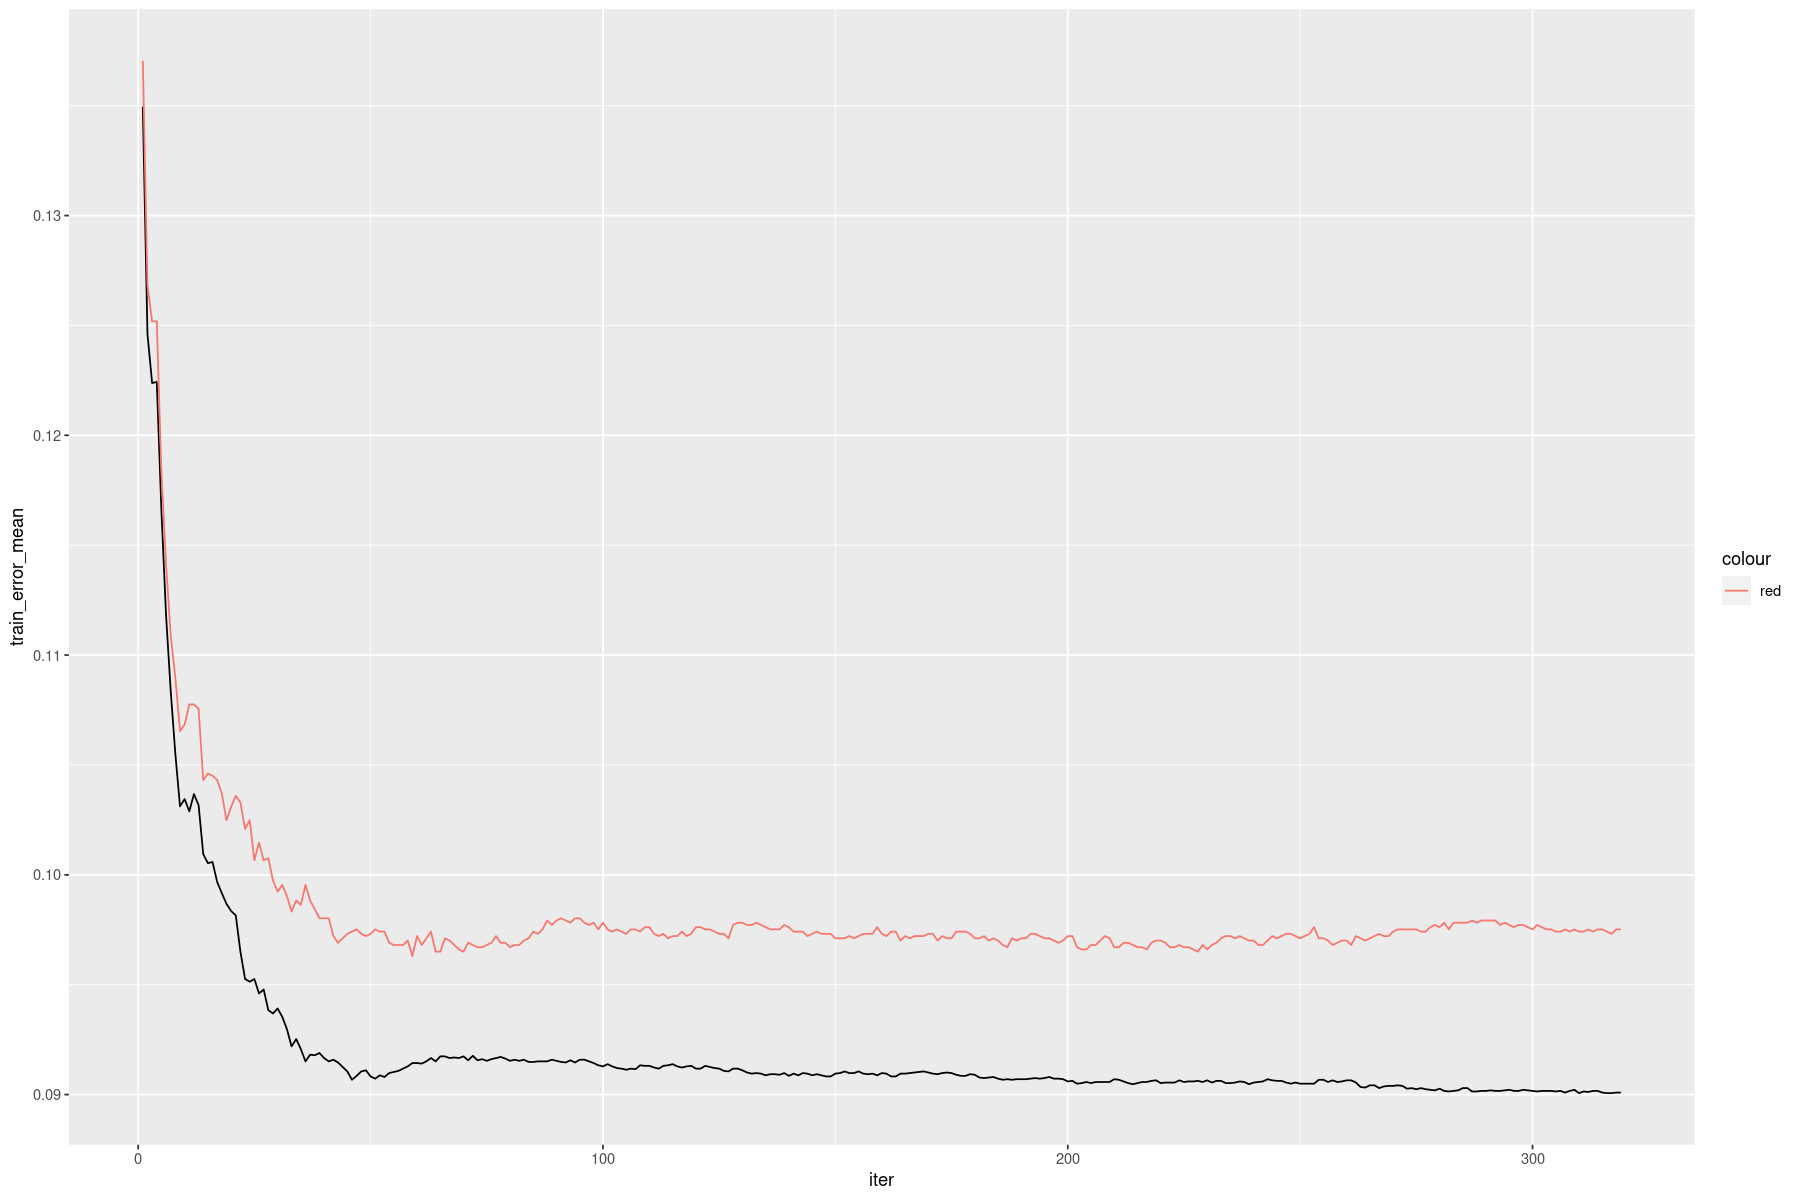

In [38]:
set.seed(42)

params <- list(
  booster = "gbtree",
  objective = "binary:logistic",
  eta = 0.1,
  max_depth = 3,
  min_child_weight = 1,
  subsample = 0.8,
  colsample_bytree = 0.5,
  gamma=10,
  eval_metric = 'error',
  eval_metric = 'logloss'
)

retention_xgb_cv7 <- xgb.cv(
  data = X_train,
  label = Y_train,
  nrounds = 400,
  nfold = 5,
  params = params,
  stratified = TRUE,
  early_stopping_rounds = 50,
  verbose = 0
)  

paste('min train error ->', min(retention_xgb_cv7$evaluation_log$train_error_mean))
paste('min val error ->', min(retention_xgb_cv7$evaluation_log$test_error_mean))

retention_xgb_cv7$evaluation_log %>% 
    ggplot(aes(iter, train_error_mean)) +
        geom_line() + 
        geom_line(aes(iter, test_error_mean, color='red'))

#### Hiper-parámetros por defecto + cambios en max_depth=1 + subsample = 0.8 + colsample_bytree = 0.5 + gamma=10

[1] "min train error -> 0.0988596"

[1] "min val error -> 0.1002524"

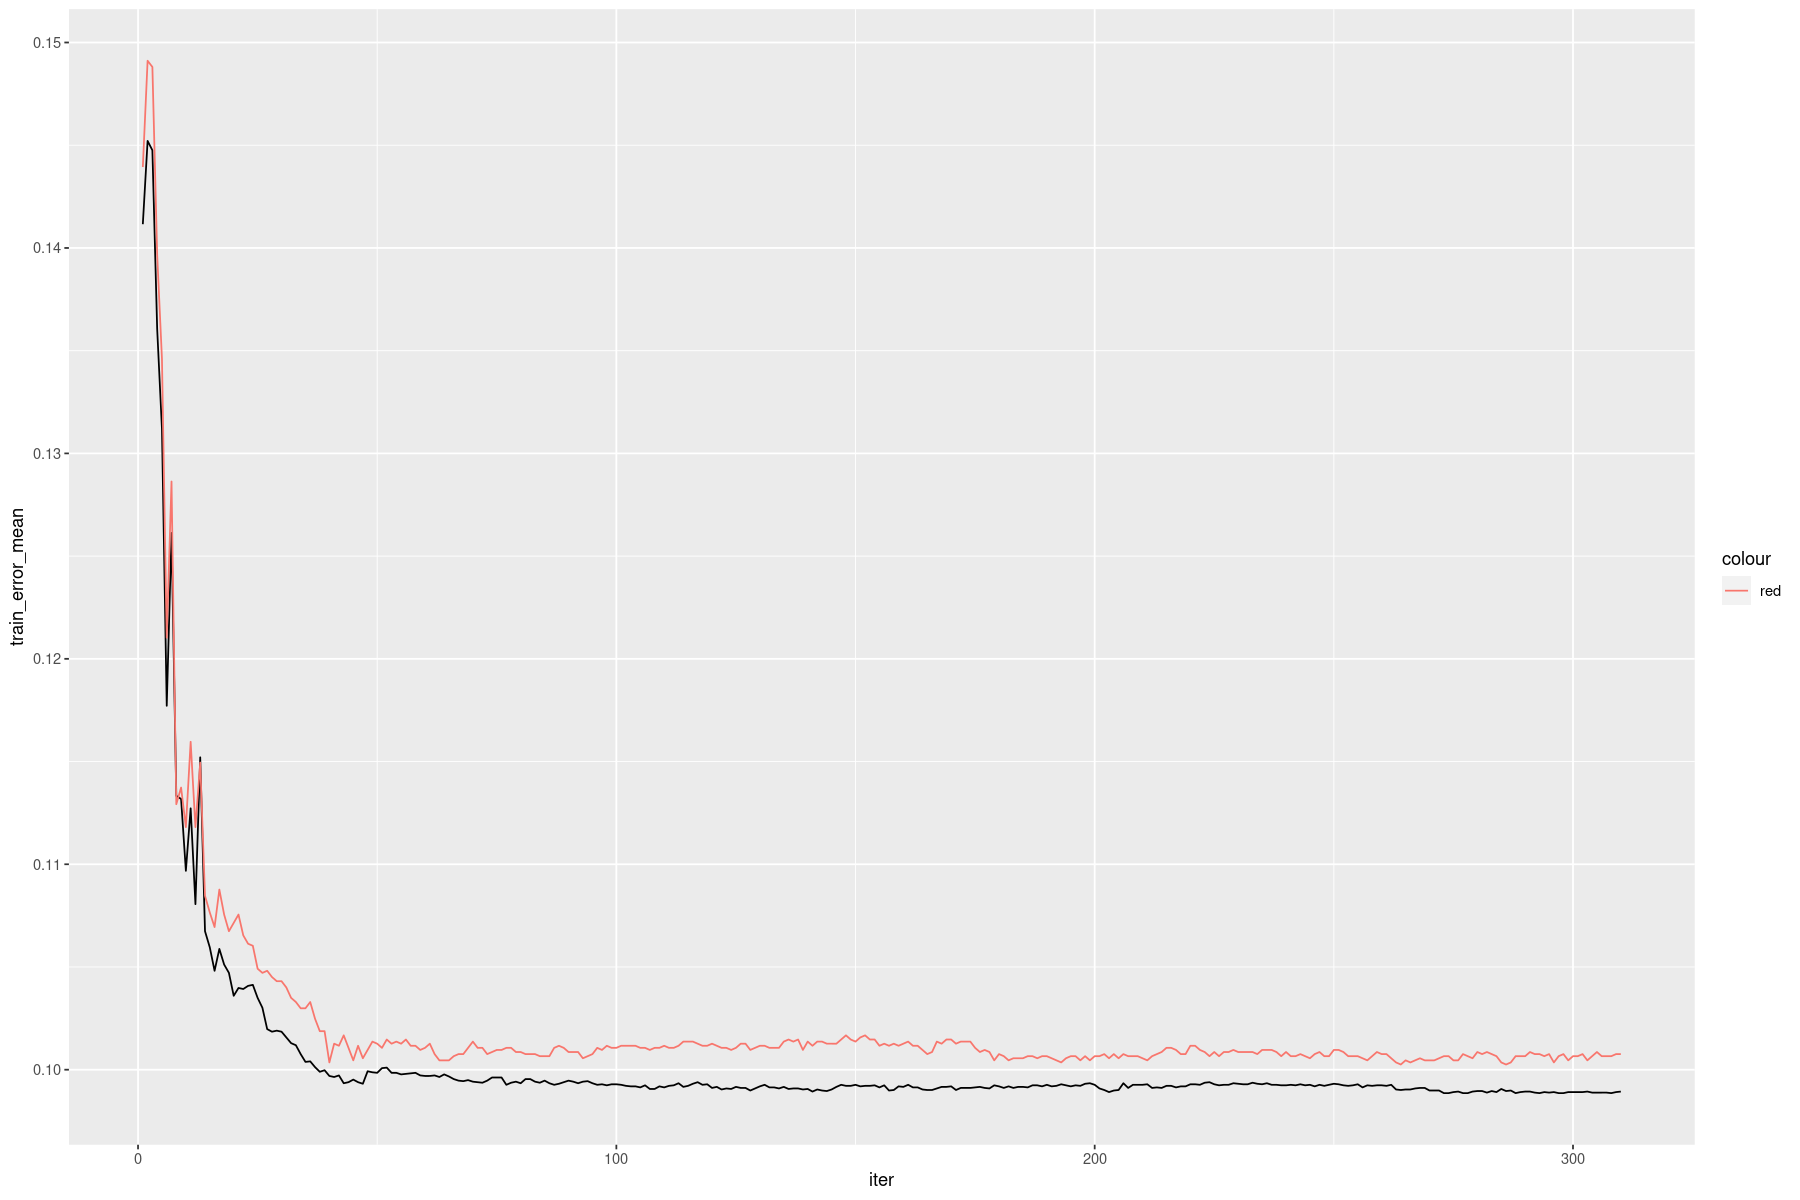

In [39]:
set.seed(42)

params <- list(
  booster = "gbtree",
  objective = "binary:logistic",
  eta = 0.2,
  max_depth = 1,
  min_child_weight = 1,
  subsample = 0.8,
  colsample_bytree = 0.5,
  gamma=10,
  eval_metric = 'error',
  eval_metric = 'logloss'
)

retention_xgb_cv8 <- xgb.cv(
  data = X_train,
  label = Y_train,
  nrounds = 400,
  nfold = 5,
  params = params,
  stratified = TRUE,
  early_stopping_rounds = 50,
  verbose = 0
)  

paste('min train error ->', min(retention_xgb_cv8$evaluation_log$train_error_mean))
paste('min val error ->', min(retention_xgb_cv8$evaluation_log$test_error_mean))

retention_xgb_cv8$evaluation_log %>% 
    ggplot(aes(iter, train_error_mean)) +
        geom_line() + 
        geom_line(aes(iter, test_error_mean, color='red'))

## Fine tuning xgboost


### Round 1

In [40]:
# hyperparameter grid
hyper_grid1 <- expand.grid(
  eta = 0.1,
  max_depth = c(1, 3, 5, 9), 
  min_child_weight = c(1, 3, 6),
  colsample_bytree = 1,
  subsample = 1,
  gamma = 0,
  logloss_train = NA,
  logloss_test = NA,
  trees = NA
)

# grid search
for(i in seq_len(nrow(hyper_grid1))) {
  set.seed(42)
  model <- xgb.cv(
    data = X_train,
    label = Y_train,
    nrounds = 100,
    objective = "binary:logistic",
    early_stopping_rounds = 50, 
    nfold = 5,
    verbose = 0,
    params = list( 
      eta = hyper_grid1$eta[i], 
      max_depth = hyper_grid1$max_depth[i],
      min_child_weight = hyper_grid1$min_child_weight[i],
      subsample = hyper_grid1$subsample[i],
      colsample_bytree = hyper_grid1$colsample_bytree[i],
      gamma = hyper_grid1$gamma[i]
    ) 
  )
  hyper_grid1$logloss_train[i] <- model$evaluation_log$train_error_mean[model$best_iteration]
  hyper_grid1$logloss_test[i] <- model$evaluation_log$test_error_mean[model$best_iteration]
  hyper_grid1$trees[i] <- model$best_iteration
  rm(model)
  gc(verbose=FALSE)
}

In [41]:
# results
hyper_grid1 %>%
  arrange(logloss_test) %>%
  head()

,eta,max_depth,min_child_weight,colsample_bytree,subsample,gamma,logloss_train,logloss_test,trees
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.1,3,6,1,1,0,0.0873036,0.0953874,67
2,0.1,3,1,1,1,0,0.0895084,0.0959954,33
3,0.1,5,1,1,1,0,0.0811710,0.0965022,16
4,0.1,3,3,1,1,0,0.0875824,0.0965024,65
5,0.1,5,3,1,1,0,0.0827674,0.0971110,22
6,0.1,5,6,1,1,0,0.0832490,0.0976174,23


### Round 2

In [42]:
# hyperparameter grid
hyper_grid2 <- expand.grid(
  eta = 0.1,
  max_depth = 3, 
  min_child_weight = c(6, 8, 10),
  colsample_bytree = 1,
  subsample = 1,
  gamma = 0,
  logloss_train = NA,
  logloss_test = NA,
  trees = NA
)

# grid search
for(i in seq_len(nrow(hyper_grid2))) {
  set.seed(42)
  model <- xgb.cv(
    data = X_train,
    label = Y_train,
    nrounds = 100,
    objective = "binary:logistic",
    early_stopping_rounds = 50, 
    nfold = 5,
    verbose = 0,
    params = list( 
      eta = hyper_grid2$eta[i], 
      max_depth = hyper_grid2$max_depth[i],
      min_child_weight = hyper_grid2$min_child_weight[i],
      subsample = hyper_grid2$subsample[i],
      colsample_bytree = hyper_grid2$colsample_bytree[i],
      gamma = hyper_grid2$gamma[i]
    ) 
  )
  hyper_grid2$logloss_train[i] <- model$evaluation_log$train_error_mean[model$best_iteration]
  hyper_grid2$logloss_test[i] <- model$evaluation_log$test_error_mean[model$best_iteration]
  hyper_grid2$trees[i] <- model$best_iteration
  print(paste("iteration ", i))
  rm(model)
  gc(verbose=FALSE)
}

[1] "iteration  1"
[1] "iteration  2"
[1] "iteration  3"


In [43]:
# results
hyper_grid2 %>%
  arrange(logloss_test) %>%
  head()

,eta,max_depth,min_child_weight,colsample_bytree,subsample,gamma,logloss_train,logloss_test,trees
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.1,3,6,1,1,0,0.0873036,0.0953874,67
2,0.1,3,8,1,1,0,0.0860870,0.0962996,92
3,0.1,3,10,1,1,0,0.0901674,0.0970096,31


### Round 3

In [44]:
# hyperparameter grid
hyper_grid3 <- expand.grid(
  eta = 0.1,
  max_depth = 3, 
  min_child_weight = 6,
  colsample_bytree = c(0.5, 0.7, 0.9),
  subsample = c(0.5, 0.7, 0.9),
  gamma = 0,
  logloss_train = NA,
  logloss_test = NA,
  trees = NA
)

# grid search
for(i in seq_len(nrow(hyper_grid3))) {
  set.seed(42)
  model <- xgb.cv(
    data = X_train,
    label = Y_train,
    nrounds = 100,
    objective = "binary:logistic",
    early_stopping_rounds = 50, 
    nfold = 5,
    verbose = 0,
    params = list( 
      eta = hyper_grid3$eta[i], 
      max_depth = hyper_grid3$max_depth[i],
      min_child_weight = hyper_grid3$min_child_weight[i],
      subsample = hyper_grid3$subsample[i],
      colsample_bytree = hyper_grid3$colsample_bytree[i],
      gamma = hyper_grid3$gamma[i]
    ) 
  )
  hyper_grid3$logloss_train[i] <- model$evaluation_log$train_error_mean[model$best_iteration]
  hyper_grid3$logloss_test[i] <- model$evaluation_log$test_error_mean[model$best_iteration]
  hyper_grid3$trees[i] <- model$best_iteration
  print(paste("iteration ", i))
  rm(model)
  gc(verbose=FALSE)
}

[1] "iteration  1"
[1] "iteration  2"
[1] "iteration  3"
[1] "iteration  4"
[1] "iteration  5"
[1] "iteration  6"
[1] "iteration  7"
[1] "iteration  8"
[1] "iteration  9"


In [45]:
# results
hyper_grid3 %>%
  arrange(logloss_test) %>%
  head()

,eta,max_depth,min_child_weight,colsample_bytree,subsample,gamma,logloss_train,logloss_test,trees
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.1,3,6,0.9,0.5,0,0.0901166,0.0953880,46
2,0.1,3,6,0.9,0.9,0,0.0884946,0.0956916,48
3,0.1,3,6,0.7,0.9,0,0.0874302,0.0957930,68
4,0.1,3,6,0.5,0.7,0,0.0888240,0.0957932,54
5,0.1,3,6,0.7,0.7,0,0.0861126,0.0960976,86
6,0.1,3,6,0.5,0.9,0,0.0867714,0.0965026,82


In [70]:
# hyperparameter grid
hyper_grid3_1 <- expand.grid(
  eta = 0.1,
  max_depth = 3, 
  min_child_weight = 6,
  subsample = c(0.3, 0.4, 0.5),
  colsample_bytree= c(0.9, 1),
  gamma = 0,
  logloss_train = NA,
  logloss_test = NA,
  trees = NA
)

# grid search
for(i in seq_len(nrow(hyper_grid3_1))) {
  set.seed(42)
  model <- xgb.cv(
    data = X_train,
    label = Y_train,
    nrounds = 100,
    objective = "binary:logistic",
    early_stopping_rounds = 50, 
    nfold = 5,
    verbose = 0,
    params = list( 
      eta = hyper_grid3_1$eta[i], 
      max_depth = hyper_grid3_1$max_depth[i],
      min_child_weight = hyper_grid3_1$min_child_weight[i],
      subsample = hyper_grid3_1$subsample[i],
      colsample_bytree = hyper_grid3_1$colsample_bytree[i],
      gamma = hyper_grid3_1$gamma[i]
    ) 
  )
  hyper_grid3_1$logloss_train[i] <- model$evaluation_log$train_error_mean[model$best_iteration]
  hyper_grid3_1$logloss_test[i] <- model$evaluation_log$test_error_mean[model$best_iteration]
  hyper_grid3_1$trees[i] <- model$best_iteration
  print(paste("iteration ", i))
  rm(model)
  gc(verbose=FALSE)
}

[1] "iteration  1"
[1] "iteration  2"
[1] "iteration  3"
[1] "iteration  4"
[1] "iteration  5"
[1] "iteration  6"


In [47]:
# results
hyper_grid3_1 %>%
  arrange(logloss_test) %>%
  head()

,eta,max_depth,min_child_weight,colsample_bytree,subsample,gamma,logloss_train,logloss_test,trees
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.1,3,6,0.5,1.0,0,0.0870500,0.0957928,85
2,0.1,3,6,0.4,0.9,0,0.0882414,0.0963000,77
3,0.1,3,6,0.5,0.9,0,0.0867714,0.0965026,82
4,0.1,3,6,0.4,1.0,0,0.0890014,0.0968064,65
5,0.1,3,6,0.3,1.0,0,0.0877342,0.0977186,95
6,0.1,3,6,0.3,0.9,0,0.0864926,0.0982254,100


### Round 4

In [48]:
# hyperparameter grid
hyper_grid4 <- expand.grid(
  eta = 0.1,
  max_depth = 3, 
  min_child_weight = 6,
  colsample_bytree = 0.5,
  subsample = 1,
  gamma = seq(0, 0.5, 0.1),
  logloss_train = NA,
  logloss_test = NA,
  trees = NA
)

# grid search
for(i in seq_len(nrow(hyper_grid4))) {
  set.seed(42)
  model <- xgb.cv(
    data = X_train,
    label = Y_train,
    nrounds = 100,
    objective = "binary:logistic",
    early_stopping_rounds = 50, 
    nfold = 5,
    verbose = 0,
    params = list( 
      eta = hyper_grid4$eta[i], 
      max_depth = hyper_grid4$max_depth[i],
      min_child_weight = hyper_grid4$min_child_weight[i],
      subsample = hyper_grid4$subsample[i],
      colsample_bytree = hyper_grid4$colsample_bytree[i],
      gamma = hyper_grid4$gamma[i]
    ) 
  )
  hyper_grid4$logloss_train[i] <- model$evaluation_log$train_error_mean[model$best_iteration]
  hyper_grid4$logloss_test[i] <- model$evaluation_log$test_error_mean[model$best_iteration]
  hyper_grid4$trees[i] <- model$best_iteration
  print(paste("iteration ", i))
  rm(model)
  gc(verbose=FALSE)
}

[1] "iteration  1"
[1] "iteration  2"
[1] "iteration  3"
[1] "iteration  4"
[1] "iteration  5"
[1] "iteration  6"


In [49]:
# results
hyper_grid4 %>%
  arrange(logloss_test) %>%
  head()

,eta,max_depth,min_child_weight,colsample_bytree,subsample,gamma,logloss_train,logloss_test,trees
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.1,3,6,0.5,1,0.0,0.0870500,0.0957928,85
2,0.1,3,6,0.5,1,0.1,0.0861630,0.0958944,94
3,0.1,3,6,0.5,1,0.2,0.0860872,0.0961986,96
4,0.1,3,6,0.5,1,0.4,0.0886468,0.0964008,68
5,0.1,3,6,0.5,1,0.5,0.0886214,0.0964008,68
6,0.1,3,6,0.5,1,0.3,0.0865180,0.0965030,94


### Round 5

In [50]:
# hyperparameter grid
hyper_grid5 <- expand.grid(
  eta = 0.1,
  max_depth = 3, 
  min_child_weight = 6,
  colsample_bytree = 0.5,
  subsample = 0.9,
  gamma = 0,
  lambda = c(0, 0.1, 1, 100),
  alpha = c(0, 0.1, 1, 100),
  logloss_train = NA,
  logloss_test = NA,
  trees = NA
)

# grid search
for(i in seq_len(nrow(hyper_grid5))) {
  set.seed(42)
  model <- xgb.cv(
    data = X_train,
    label = Y_train,
    nrounds = 300,
    objective = "binary:logistic",
    early_stopping_rounds = 50, 
    nfold = 5,
    verbose = 0,
    params = list( 
      eta = hyper_grid5$eta[i], 
      max_depth = hyper_grid5$max_depth[i],
      min_child_weight = hyper_grid5$min_child_weight[i],
      subsample = hyper_grid5$subsample[i],
      colsample_bytree = hyper_grid5$colsample_bytree[i],
      gamma = hyper_grid5$gamma[i]
    ) 
  )
  hyper_grid5$logloss_train[i] <- model$evaluation_log$train_error_mean[model$best_iteration]
  hyper_grid5$logloss_test[i] <- model$evaluation_log$test_error_mean[model$best_iteration]
  hyper_grid5$trees[i] <- model$best_iteration
  print(paste("iteration ", i))
  rm(model)
  gc(verbose=FALSE)
}

[1] "iteration  1"
[1] "iteration  2"
[1] "iteration  3"
[1] "iteration  4"
[1] "iteration  5"
[1] "iteration  6"
[1] "iteration  7"
[1] "iteration  8"
[1] "iteration  9"
[1] "iteration  10"
[1] "iteration  11"
[1] "iteration  12"
[1] "iteration  13"
[1] "iteration  14"
[1] "iteration  15"
[1] "iteration  16"


In [51]:
# results
hyper_grid5 %>%
  arrange(logloss_test) %>%
  head()

,eta,max_depth,min_child_weight,colsample_bytree,subsample,gamma,lambda,alpha,logloss_train,logloss_test,trees
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.1,3,6,0.5,0.9,0,0.0,0.0,0.0867714,0.0965026,82
2,0.1,3,6,0.5,0.9,0,0.1,0.0,0.0867714,0.0965026,82
3,0.1,3,6,0.5,0.9,0,1.0,0.0,0.0867714,0.0965026,82
4,0.1,3,6,0.5,0.9,0,100.0,0.0,0.0867714,0.0965026,82
5,0.1,3,6,0.5,0.9,0,0.0,0.1,0.0867714,0.0965026,82
6,0.1,3,6,0.5,0.9,0,0.1,0.1,0.0867714,0.0965026,82


### Final Round

In [52]:
# hyperparameter grid
hyper_grid6 <- expand.grid(
  eta = c(0.1, 0.05, 0.01),
  max_depth = 3, 
  min_child_weight = 6,
  colsample_bytree = 0.5,
  subsample = 0.9,
  gamma = 0,
  lambda = 0,
  alpha = 0,
  logloss_train = NA,
  logloss_test = NA,
  trees = NA
)

# grid search
for(i in seq_len(nrow(hyper_grid6))) {
  set.seed(42)
  model <- xgb.cv(
    data = X_train,
    label = Y_train,
    nrounds = 300,
    objective = "binary:logistic",
    early_stopping_rounds = 50, 
    nfold = 5,
    verbose = 0,
    params = list( 
      eta = hyper_grid6$eta[i], 
      max_depth = hyper_grid6$max_depth[i],
      min_child_weight = hyper_grid6$min_child_weight[i],
      subsample = hyper_grid6$subsample[i],
      colsample_bytree = hyper_grid6$colsample_bytree[i],
      gamma = hyper_grid6$gamma[i]
    ) 
  )
  hyper_grid6$logloss_train[i] <- model$evaluation_log$train_error_mean[model$best_iteration]
  hyper_grid6$logloss_test[i] <- model$evaluation_log$test_error_mean[model$best_iteration]
  hyper_grid6$trees[i] <- model$best_iteration
  print(paste("iteration ", i))
  rm(model)
  gc(verbose=FALSE)
}

[1] "iteration  1"
[1] "iteration  2"
[1] "iteration  3"


In [53]:
# results
hyper_grid6 %>%
  arrange(logloss_test) %>%
  head()

,eta,max_depth,min_child_weight,colsample_bytree,subsample,gamma,lambda,alpha,logloss_train,logloss_test,trees
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.05,3,6,0.5,0.9,0,0,0,0.0861886,0.0950834,194
2,0.10,3,6,0.5,0.9,0,0,0,0.0867714,0.0965026,82
3,0.01,3,6,0.5,0.9,0,0,0,0.0919918,0.0982256,300


### Best Model

#### CV

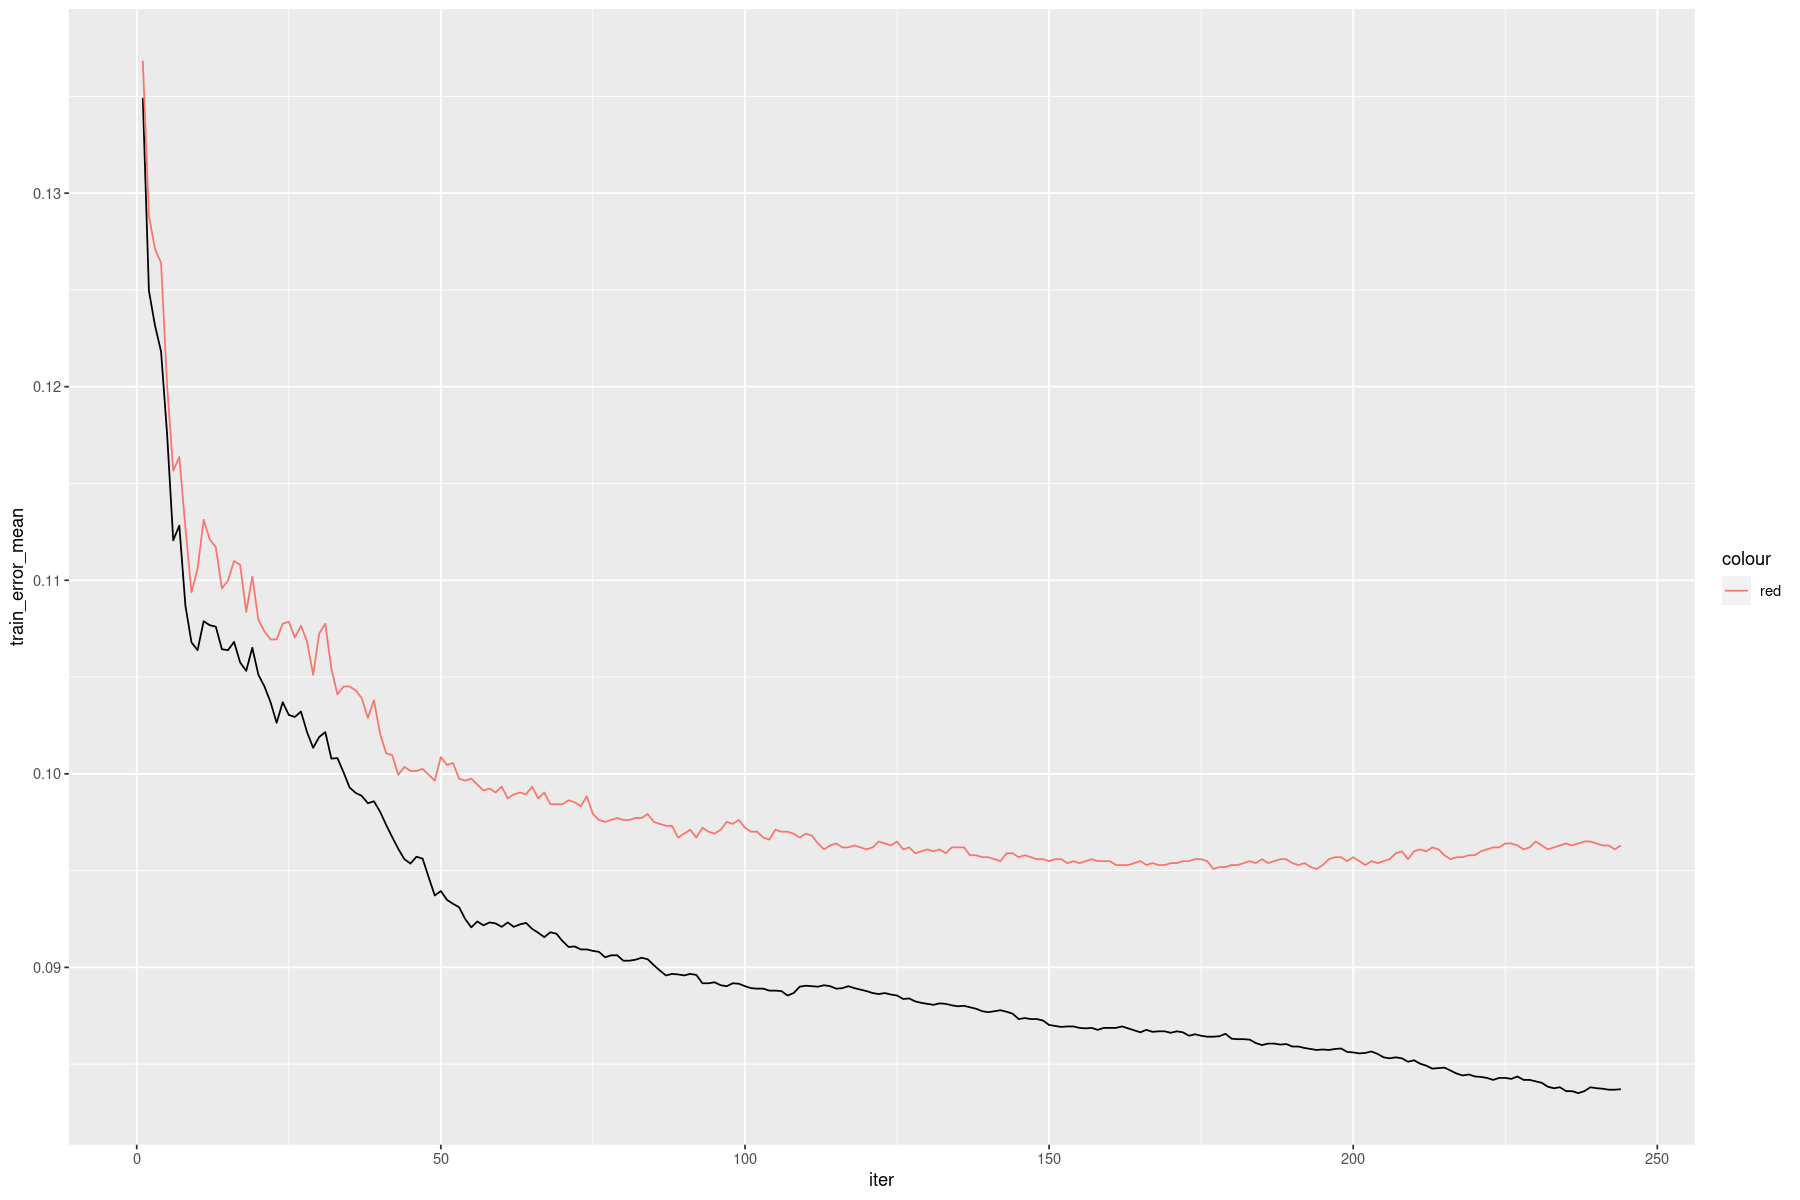

In [54]:
# hyperparameter grid
hyper_grid6 <- expand.grid(
  eta = 0.05,
  max_depth = 3, 
  min_child_weight = 6,
  colsample_bytree = 0.5,
  subsample = 0.9,
  gamma = 0,
  lambda = 0,
  alpha = 0,
  logloss_train = NA,
  logloss_test = NA,
  trees = NA
)

set.seed(42)
best_model_cv <- xgb.cv(
    data = X_train,
    label = Y_train,
    nrounds = 300,
    objective = "binary:logistic",
    early_stopping_rounds = 50, 
    nfold = 5,
    verbose = 0,
    params = list(
      eta = 0.05,
      max_depth = 3, 
      min_child_weight = 6,
      colsample_bytree = 0.5,
      subsample = 0.9,
      gamma = 0,
      lambda = 0,
      alpha = 0
    )
)

best_model_cv$evaluation_log %>% 
    ggplot(aes(iter, train_error_mean)) +
        geom_line() + 
        geom_line(aes(iter, test_error_mean, color='red'))

In [55]:
best_model_cv$best_iteration

[1] 194

#### Best

In [56]:
set.seed(42)
final_model_xgb <- xgboost(
data = X_train,
label = Y_train,
nrounds = 194,
objective = "binary:logistic",
early_stopping_rounds = 50, 
verbose = 0,
params = list( 
    eta = 0.05, 
    max_depth = 3,
    min_child_weight = 6,
    subsample = 0.5,
    colsample_bytree = 0.9,
    gamma = 0,
    lambda = 0, 
    alpha = 0
    ) 
)

In [57]:
data_to_eval = X_train
real_target = Y_train
pred_retention <- predict(final_model_xgb, newdata = data_to_eval, type='response')

confusionMatrix(data = as.factor(ifelse(pred_retention>0.5, 1, 0)),
                reference = as.factor(real_target),
                positive='1',
                mode='prec_recall'
               )

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 8040  556
         1  298  971
                                          
               Accuracy : 0.9134          
                 95% CI : (0.9077, 0.9189)
    No Information Rate : 0.8452          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6446          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
              Precision : 0.76517         
                 Recall : 0.63589         
                     F1 : 0.69456         
             Prevalence : 0.15479         
         Detection Rate : 0.09843         
   Detection Prevalence : 0.12864         
      Balanced Accuracy : 0.80007         
                                          
       'Positive' Class : 1               
                                          

In [58]:
data_to_eval = X_test
real_target = Y_test
pred_retention <- predict(final_model_xgb, newdata = data_to_eval, type='response')

confusionMatrix(data = as.factor(ifelse(pred_retention>0.5, 1, 0)),
                reference = as.factor(real_target),
                positive='1',
                mode='prec_recall'
               )

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2002  149
         1   82  232
                                          
               Accuracy : 0.9063          
                 95% CI : (0.8941, 0.9175)
    No Information Rate : 0.8454          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6137          
                                          
 Mcnemar's Test P-Value : 1.409e-05       
                                          
              Precision : 0.73885         
                 Recall : 0.60892         
                     F1 : 0.66763         
             Prevalence : 0.15456         
         Detection Rate : 0.09412         
   Detection Prevalence : 0.12738         
      Balanced Accuracy : 0.78479         
                                          
       'Positive' Class : 1               
                                          

In [59]:
data_to_eval = X_test
real_target = Y_test
pred_retention <- predict(final_model_xgb, newdata = data_to_eval, type='response')

confusionMatrix(data = as.factor(ifelse(pred_retention>0.5, 1, 0)),
                reference = as.factor(real_target),
                positive='1',
                mode='prec_recall'
               )

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2002  149
         1   82  232
                                          
               Accuracy : 0.9063          
                 95% CI : (0.8941, 0.9175)
    No Information Rate : 0.8454          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6137          
                                          
 Mcnemar's Test P-Value : 1.409e-05       
                                          
              Precision : 0.73885         
                 Recall : 0.60892         
                     F1 : 0.66763         
             Prevalence : 0.15456         
         Detection Rate : 0.09412         
   Detection Prevalence : 0.12738         
      Balanced Accuracy : 0.78479         
                                          
       'Positive' Class : 1               
                                          

### Feature interpretation

Al igual que RF, GBM implementan impurity para obtener las features que más influyen en la reducción de la loss en la predicción. Sin embargo XGBoost implementa un par mas:

* **Gain**: es el equivalente al usado en RF (impurity)
* **Coverage**: cuantifica el número relativo de observaciones que se usó de una feature para llegar a una hoja.
* **Frequency**: Porcentaje del número de veces que una feature fue usada para hacer un split entre todos los árboles


In [60]:
importance_matrix <- xgb.importance(model=final_model_xgb)

In [61]:
head(importance_matrix)

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
PageValues,0.63973938,0.24776106,0.15130435
ProductRelated_Duration,0.06154302,0.12100894,0.15391304
Month_Nov,0.05739314,0.11739750,0.07130435
ExitRates,0.04707693,0.08809944,0.11304348
Administrative_Duration,0.03929787,0.07884848,0.12260870
BounceRates,0.03704036,0.04768712,0.07304348


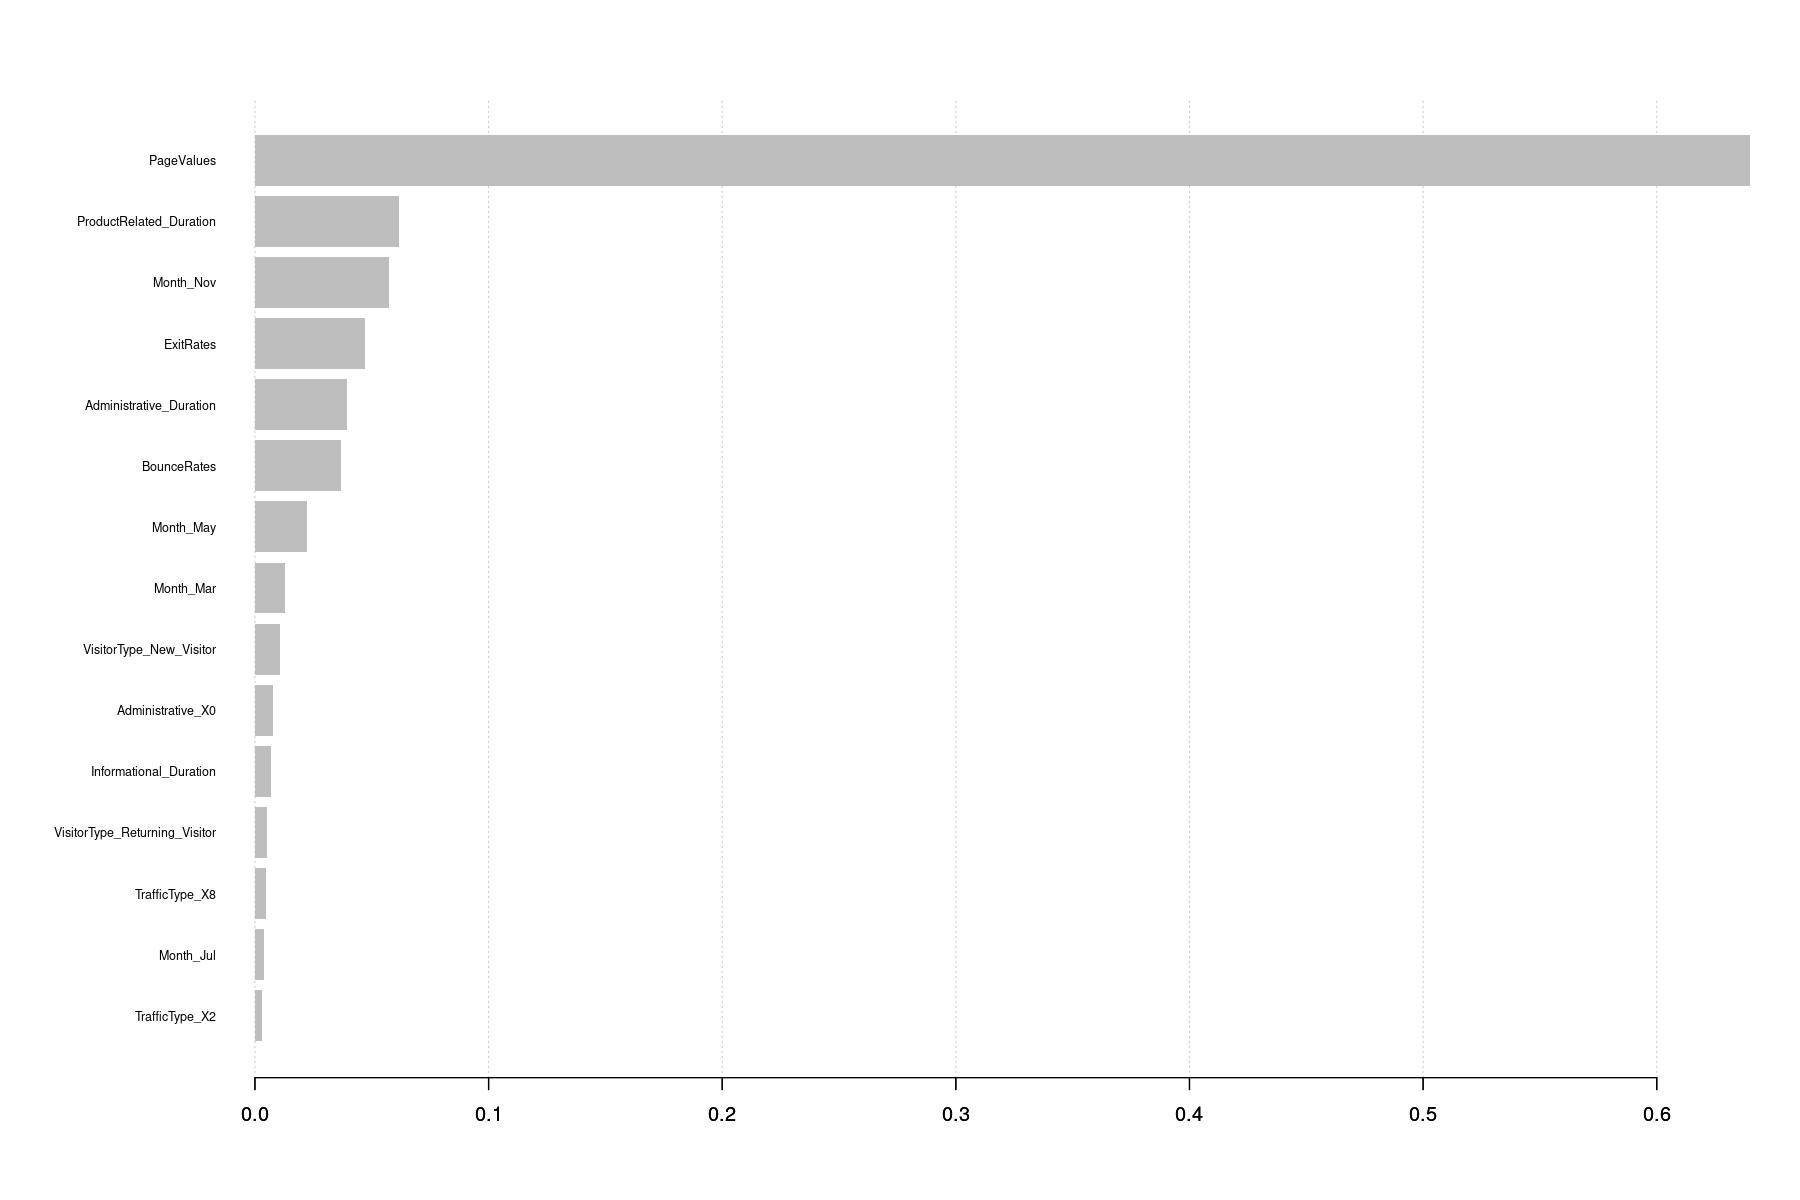

In [62]:
xgb.plot.importance(importance_matrix = importance_matrix, top_n=15)

Warning message:
“`as.tibble()` is deprecated as of tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


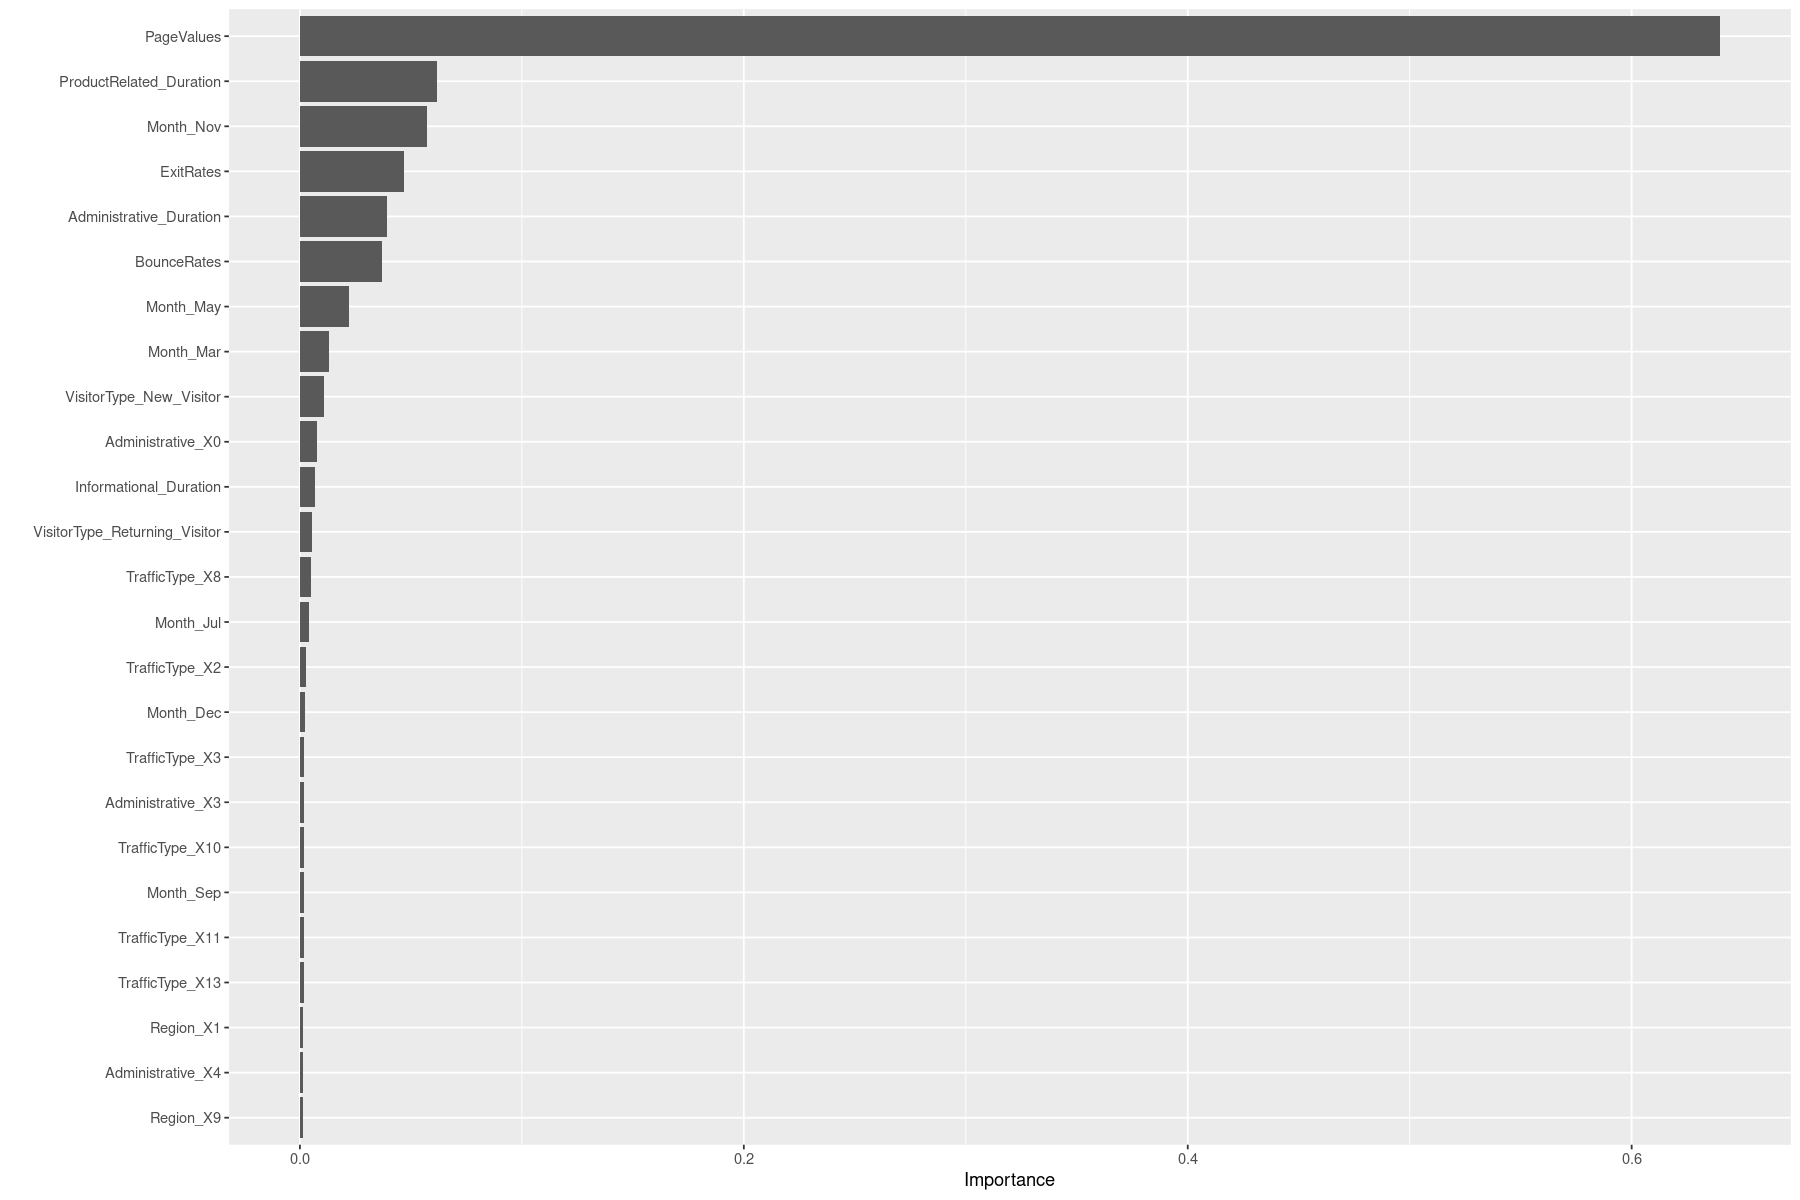

In [63]:
vip::vip(final_model_xgb, type="gain", num_features = 25)

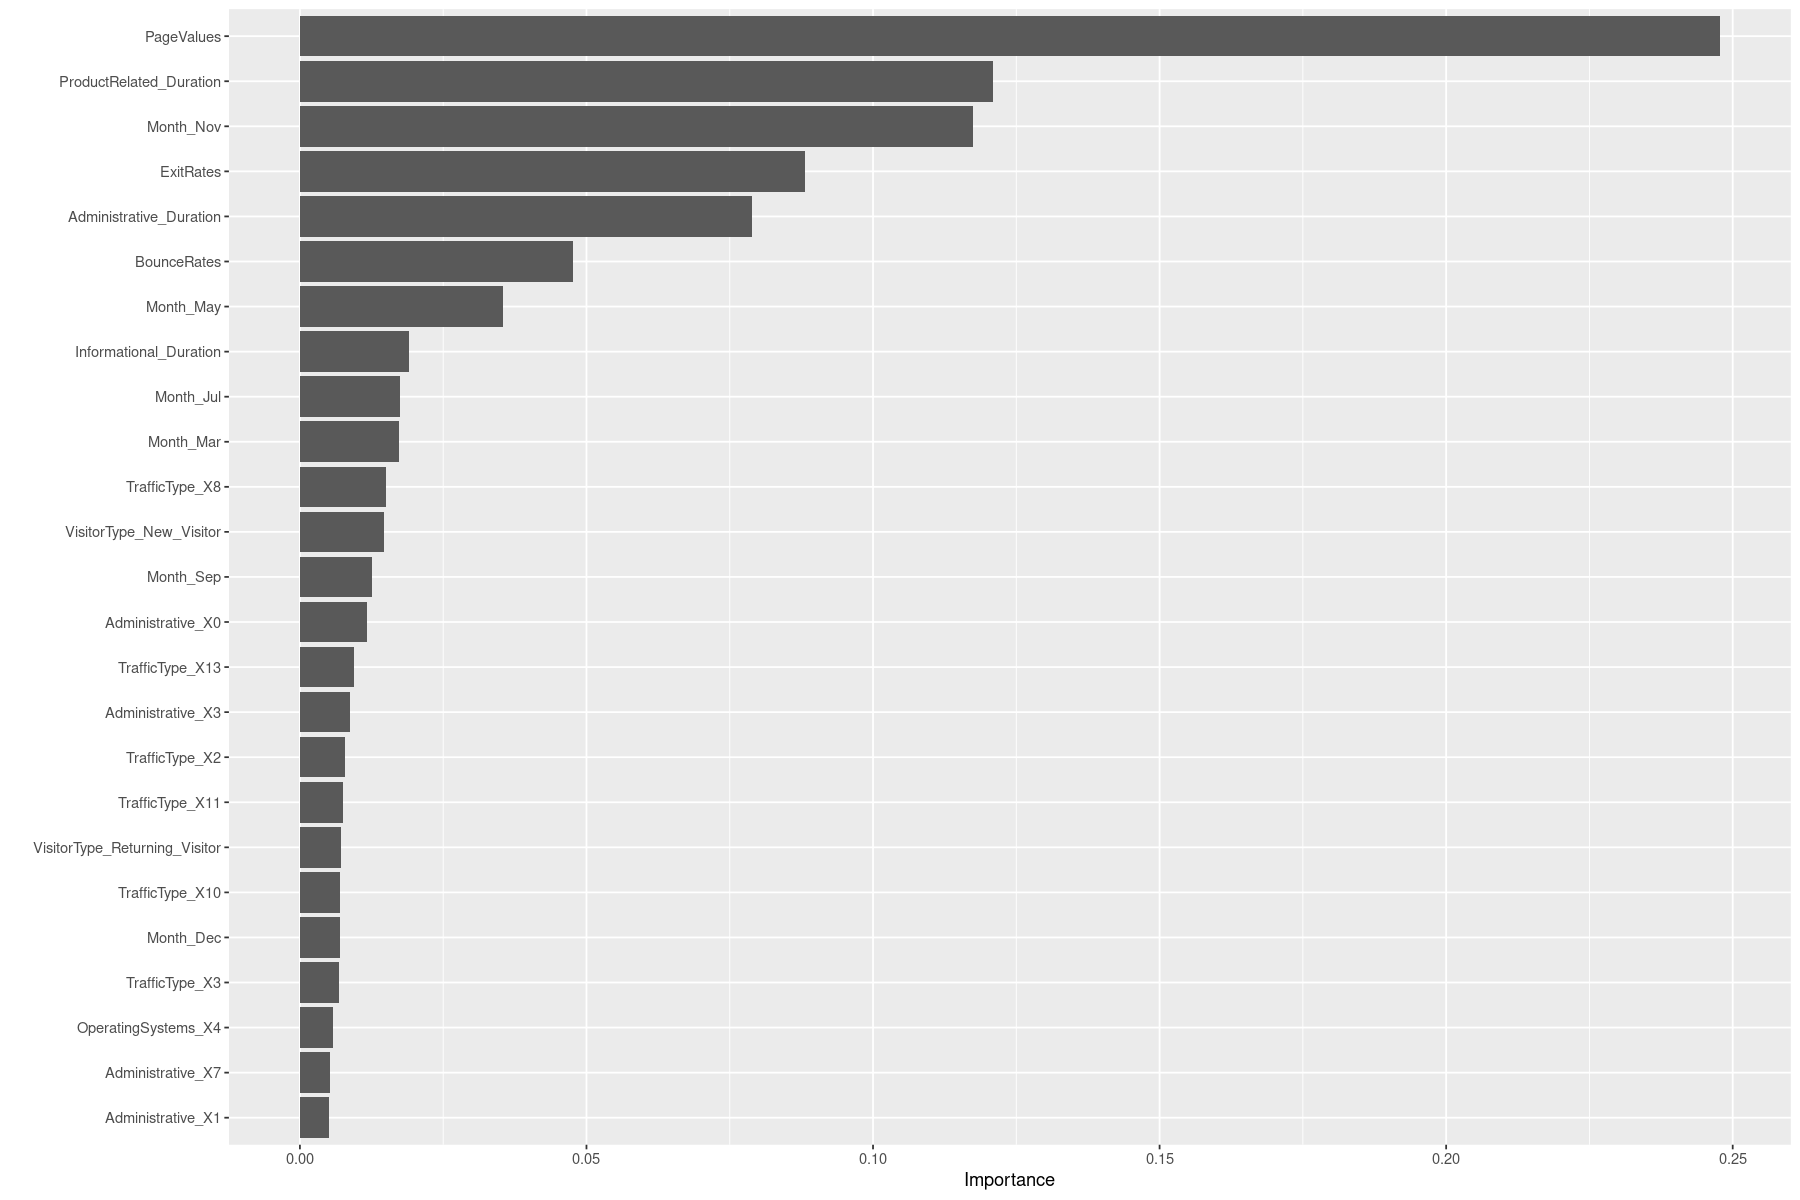

In [64]:
vip::vip(final_model_xgb, type="cover", num_features = 25)

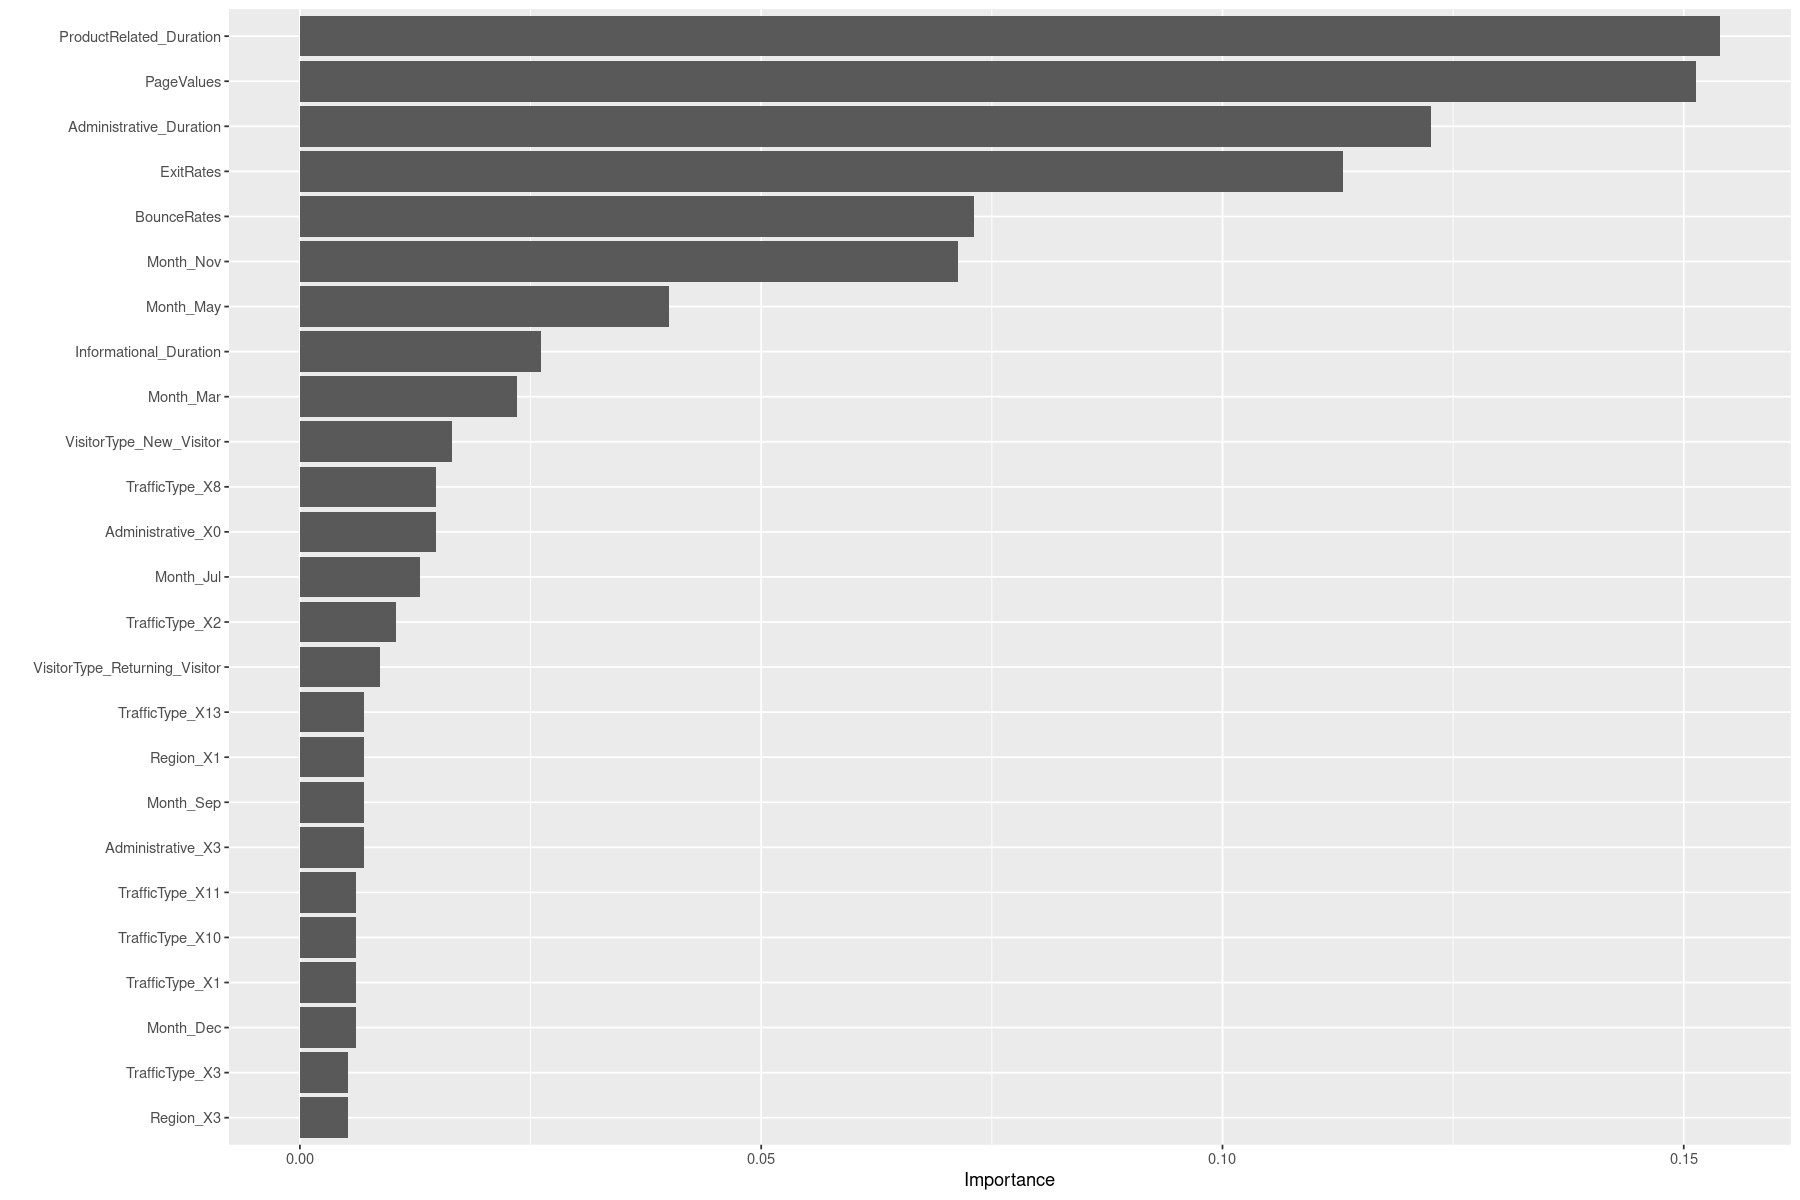

In [65]:
vip::vip(final_model_xgb, type="frequency", num_features = 25)

Warning message:
“Use of `object[[1L]]` is discouraged. Use `.data[[1L]]` instead.”
Warning message:
“Use of `object[["yhat"]]` is discouraged. Use `.data[["yhat"]]` instead.”
Warning message:
“Use of `x.rug[[1L]]` is discouraged. Use `.data[[1L]]` instead.”


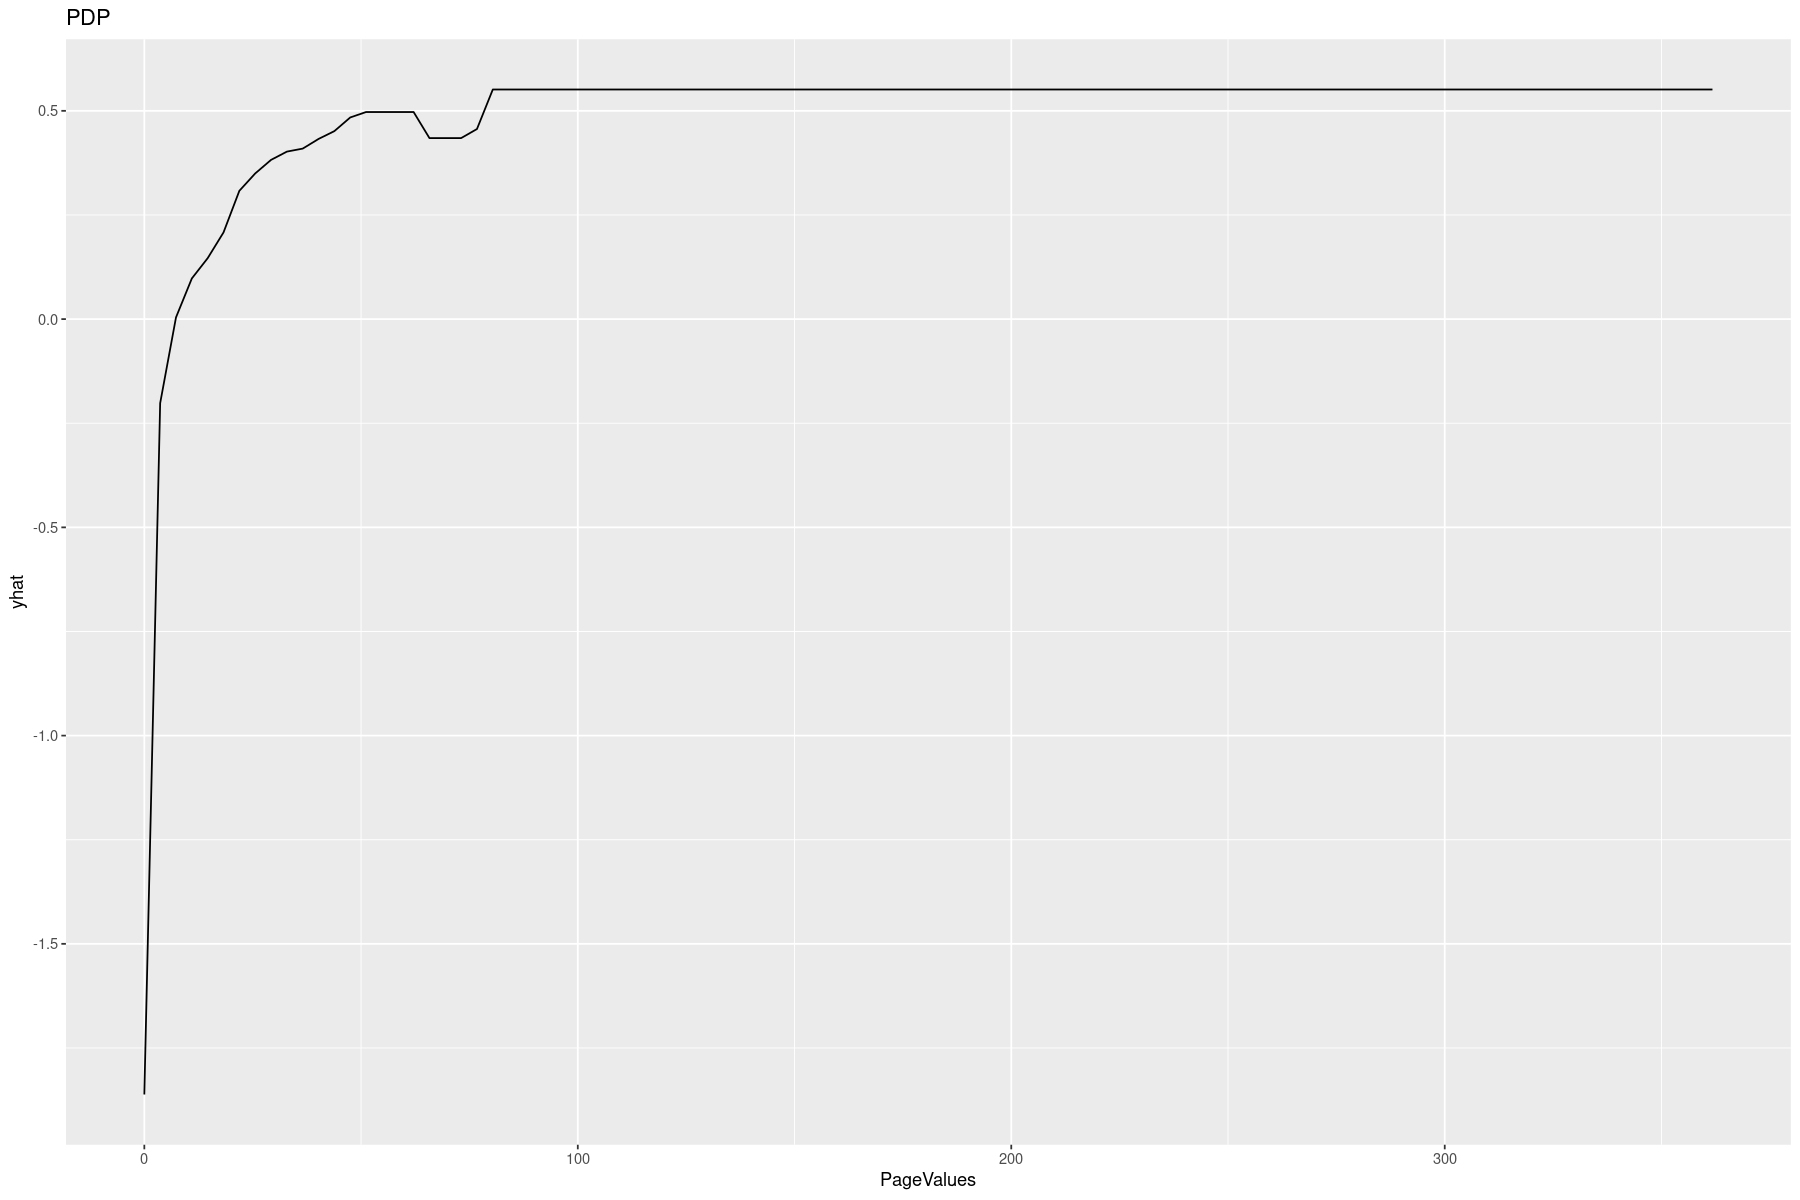

In [66]:
final_model_xgb %>%
  pdp::partial(pred.var = "PageValues", grid.resolution = 100, train = X_train) %>%
  autoplot(rug = TRUE, train = X_train) +
  ggtitle("PDP")


Warning message:
“Use of `object[[1L]]` is discouraged. Use `.data[[1L]]` instead.”
Warning message:
“Use of `object[["yhat"]]` is discouraged. Use `.data[["yhat"]]` instead.”
Warning message:
“Use of `x.rug[[1L]]` is discouraged. Use `.data[[1L]]` instead.”


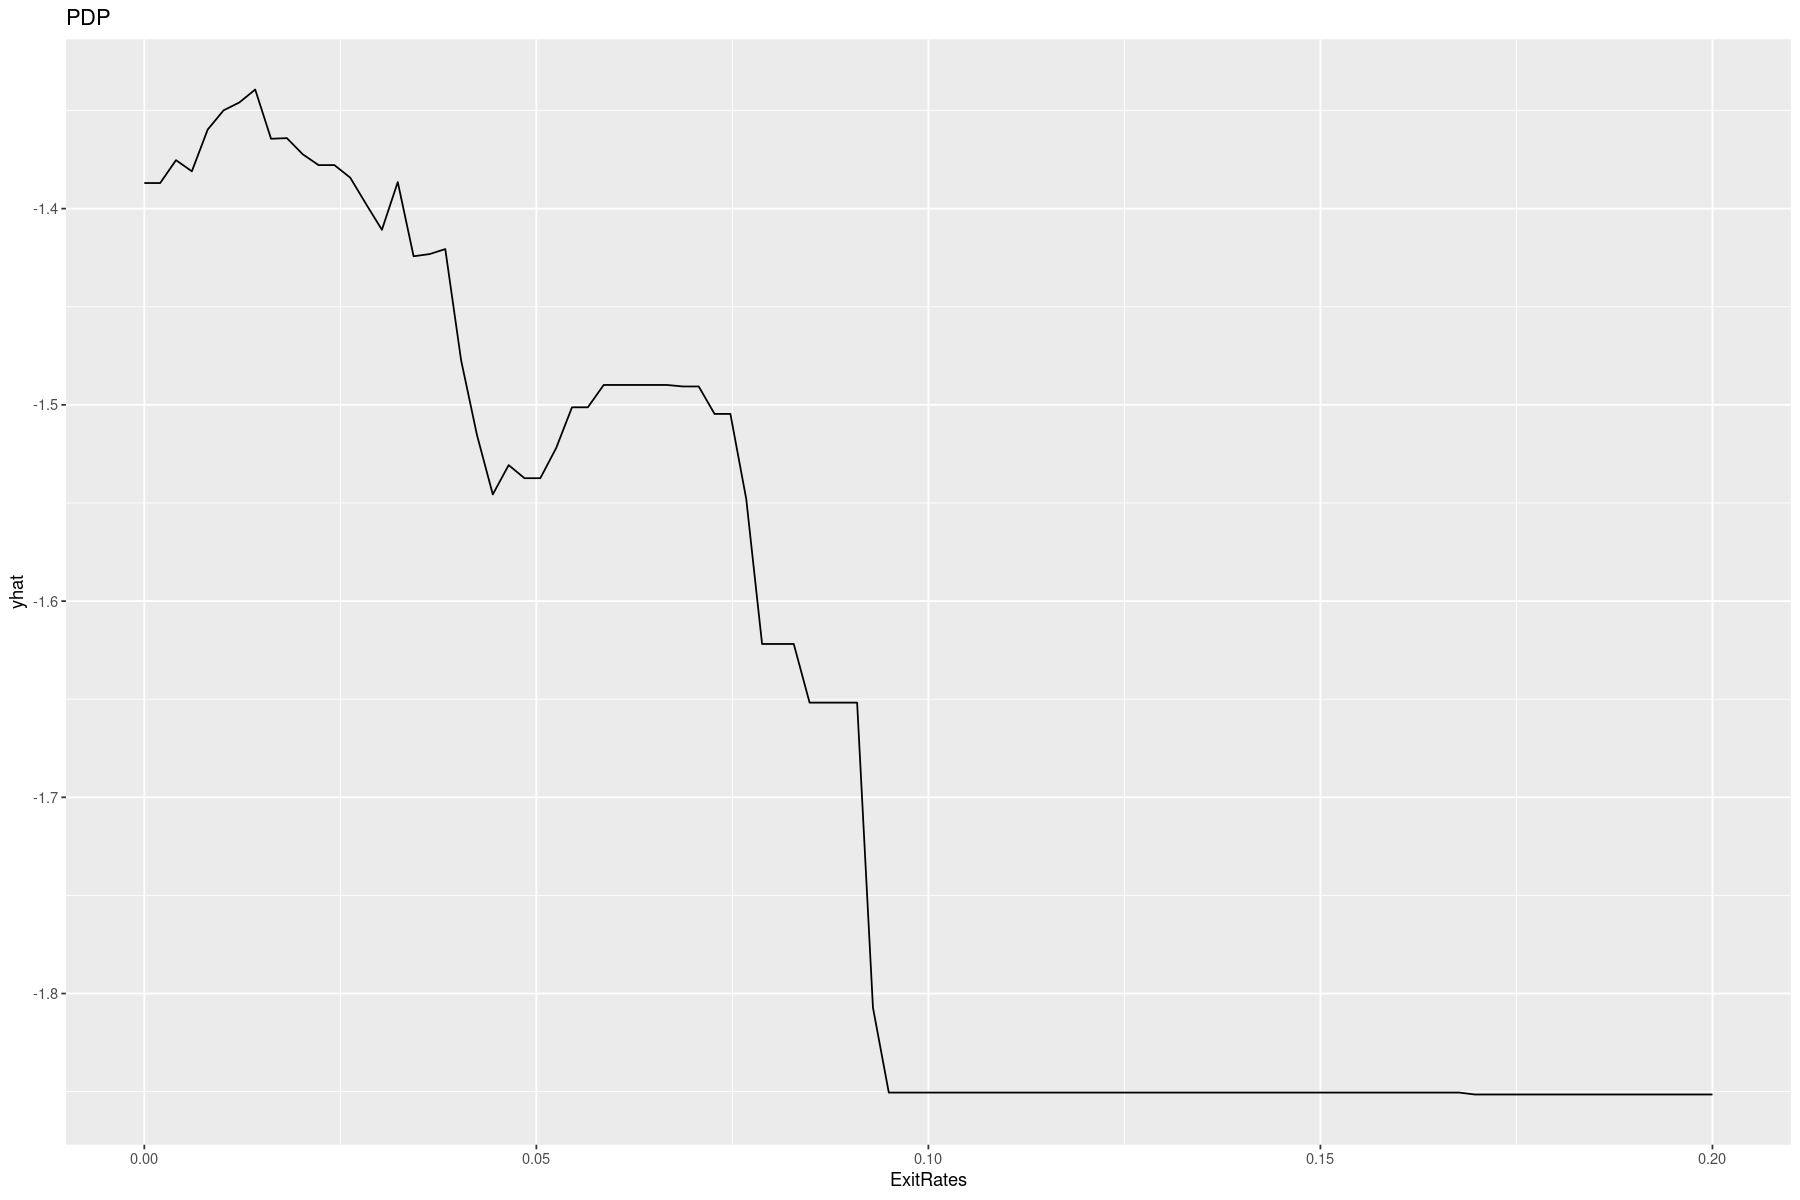

In [67]:
final_model_xgb %>%
  pdp::partial(pred.var = "ExitRates", grid.resolution = 100, train = X_train) %>%
  autoplot(rug = TRUE, train = X_train) +
  ggtitle("PDP")


partial dependence plots (PDPs) and individual conditional expectation (ICE) curves

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“Ignoring unknown parameters: csides”
Warning message:
“Use of `object[[1L]]` is discouraged. Use `.data[[1L]]` instead.”
Warning message:
“Use of `object[["yhat"]]` is discouraged. Use `.data[["yhat"]]` instead.”
Warning message:
“Use of `x.rug[[1L]]` is discouraged. Use `.data[[1L]]` instead.”
Warning message:
“Use of `object[["yhat.id"]]` is discouraged. Use `.data[["yhat.id"]]` instead.”
Warning message:
“Use of `object[[1L]]` is discouraged. Use `.data[[1L]]` instead.”
Warning message:
“Use of `object[["yhat"]]` is discouraged. Use `.data[["yhat"]]` instead.”
Warning message:
“Use of `object[[1L]]` is discouraged. Use `.data[[1L]]` instead.”
Warning message:
“Use of `object[["yhat"]]` is discouraged. Use `.data[["yhat"]]` instead.”
Warning message:
“Use of `x.rug[[1L]]` is discouraged. Use `.data[[1L]]` instead.”
Warning message:
“Removed 345275 rows containing non-finite values (stat_summary).”
Warning 

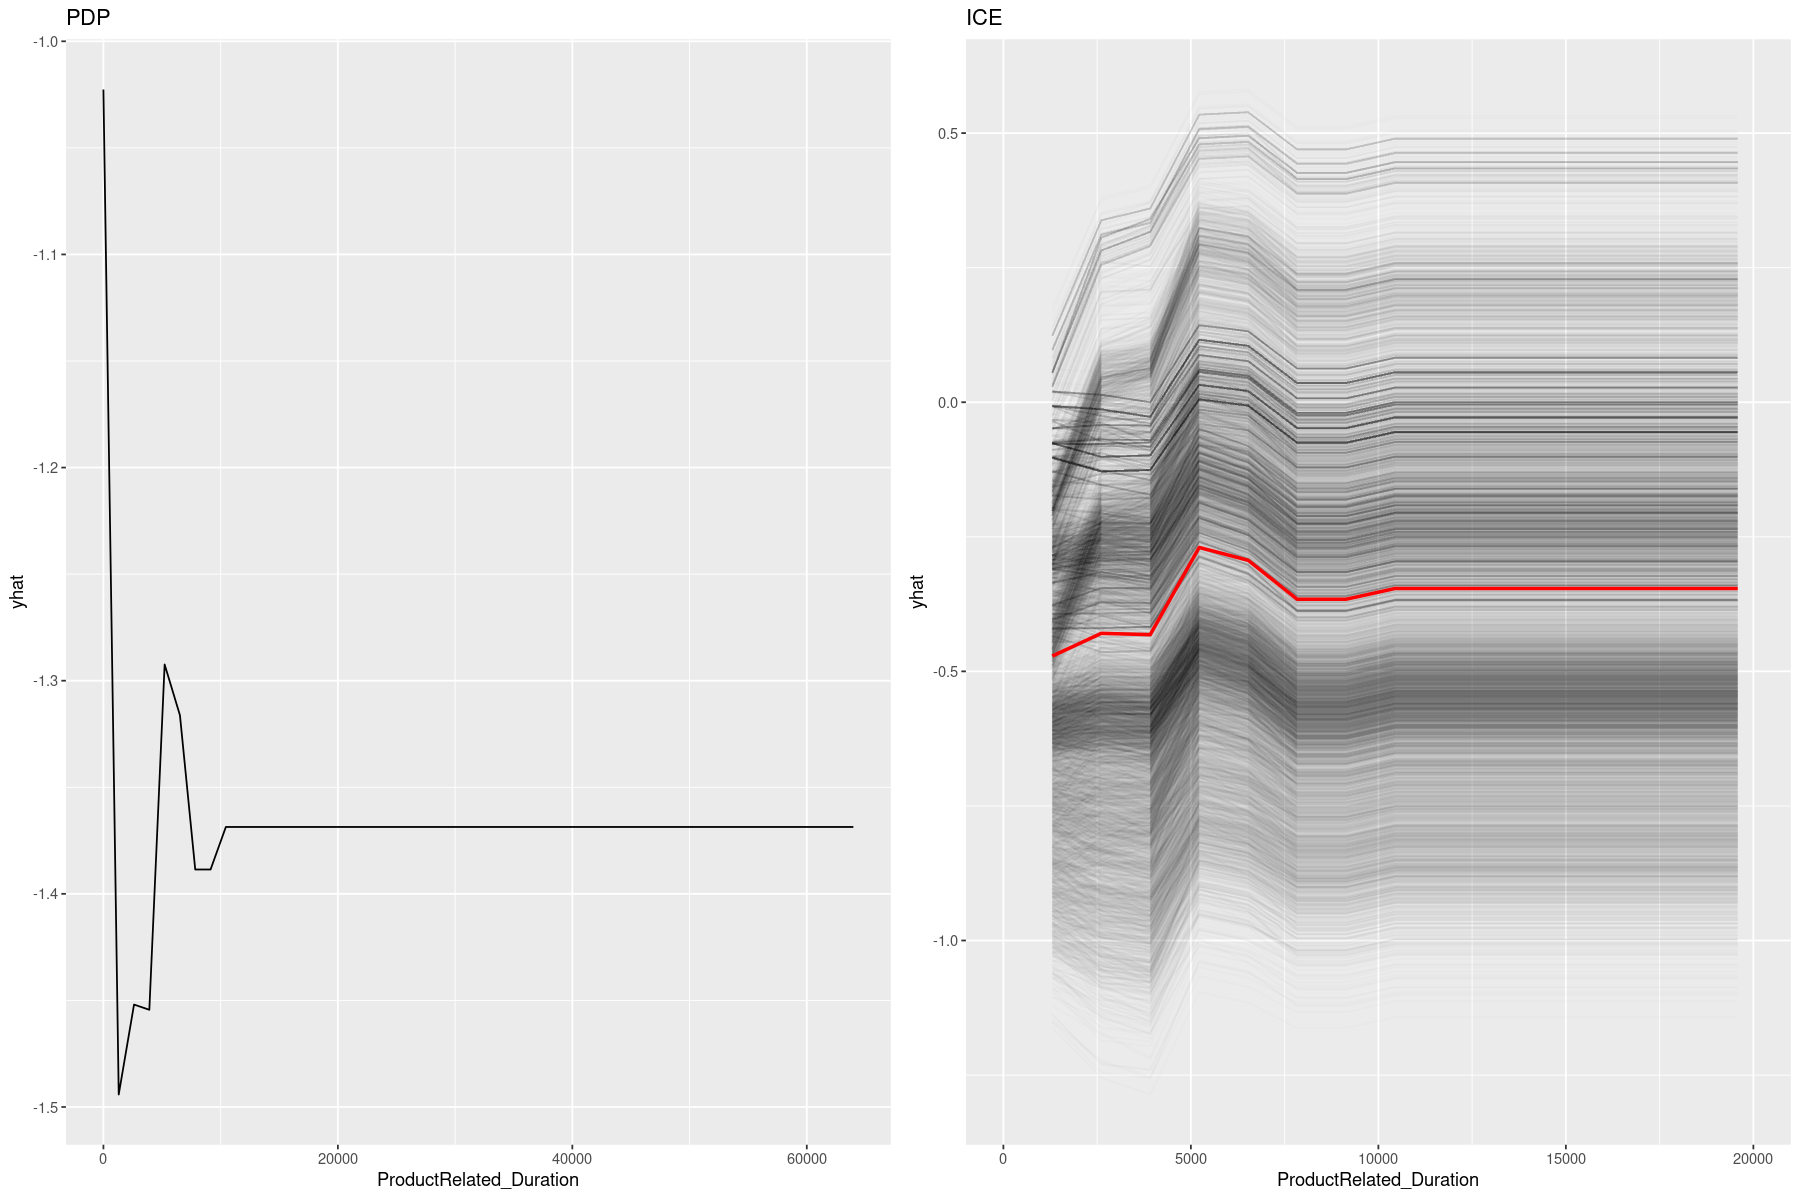

In [68]:
pdp_plot <- final_model_xgb %>%
  partial(pred.var = "ProductRelated_Duration", grid.resolution = 50, train = X_train) %>%
  autoplot(rug = TRUE, train = X_train) +
  ggtitle("PDP")

ice_plot <- final_model_xgb %>%
  partial(pred.var = "ProductRelated_Duration", grid.resolution = 50, train = X_train, ice = TRUE) %>%
  autoplot(rug = TRUE, train = X_train, alpha = .01, center = TRUE) +
  xlim(1, 20000) +
  ggtitle("ICE")

gridExtra::grid.arrange(pdp_plot, ice_plot, nrow = 1)

## Save model

In [69]:
# Save model
xgb.save(final_model_xgb, "xgboost.model")
# load binary model to R
best_model <- xgb.load("xgboost.model")
pred2 <- predict(best_model, X_test)

[1] TRUE

[Online shopping intention competition](https://www.kaggle.com/roshansharma/online-shoppers-intention/notebooks)